# Introduction
Assuming the role of a data scientist at an investment firm, I'm embarking on a project focused on big tech companies. I've selected eight major players: Meta, Apple, Amazon, Netflix, Google, Nvidia, Microsoft, and Tesla. This analysis will be presented through a report or program to the investment manager, deployed via Streamlit to ensure it is always accessible. Our exploration will delve into the stock data of FAANG companies, part of the broader S&P 500 index, which includes 500 publicly traded companies on the NYSE and NASDAQ Composite. Established in 1957, the S&P 500 serves as a critical barometer of the U.S. economy, reflecting the dynamics of its largest and most influential companies. Our comprehensive journey through this project will cover extracting, visualizing, analyzing, and forecasting stock prices using various methodologies, providing key insights into the health and trends of these tech giants.

# Imports

In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpdates
import seaborn as sns
import yfinance as yf
from yahoo_fin import stock_info

import datetime
from dateutil.parser import parse

from IPython.display import Image

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

In [4]:
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [5]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [6]:
from prophet import Prophet
from prophet.plot import plot_plotly

In [7]:
from datetime import datetime

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Scraping the Data
To gather the stock information of S&P 500 firms, we can utilize yfinance and yahoo-fin, which offer APIs that greatly simplify and facilitate web scraping. By employing this web scraper, I succeeded in generating a dataset that updates daily, pulling the stock data of S&P 500 companies.

## How the Web Scraper Works:
* We collect a list of tickers which are the stock abbreviations for all the S&P500 companies. We makes use of the tickers_sp500() function which contains the list of all the the companies that compose the S&P500.
* We iterate over the length of the tickers list and collect the historical stock prices for that particular company. The yf.Ticker() function accepts the name of the company. We then collect the stock prices of the company using history(period = 'max').
* The final file is named using dataframe_names[i] and stored in .csv format.

In [9]:
# tickers = stock_info.tickers_sp500()
# dataframe_names = [ticker for ticker in tickers]
# print('Web scraper starting.....')
# for i in range(len(tickers)):
#   historical_stock_prices = (yf.Ticker(tickers[i])).history(period = 'max')
#   historical_stock_prices.to_csv(dataframe_names[i] + '.csv')

In [10]:
# Define the specific tickers you are interested in
tickers = ['AAPL', 'AMZN', 'META', 'NFLX', 'GOOG', 'NVDA', 'MSFT', 'TSLA']

print('Web scraper starting.....')

# Loop through the list of tickers
for ticker in tickers:
    # Create a Ticker object for each ticker
    stock = yf.Ticker(ticker)
    # Get historical prices for this ticker
    historical_stock_prices = stock.history(period='max')
    # Save the data to a CSV file named after the ticker
    historical_stock_prices.to_csv(ticker + '.csv')

print('Scraping complete.')

Web scraper starting.....
Scraping complete.


In [11]:
# taking a look at the scraped data
pd.read_csv('NVDA.csv').tail(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
6349,2024-04-17 00:00:00-04:00,883.400024,887.750000,839.500000,840.349976,49540000,0.0,0.0
6350,2024-04-18 00:00:00-04:00,849.700012,861.900024,824.020020,846.710022,44726000,0.0,0.0
6351,2024-04-19 00:00:00-04:00,831.500000,843.239990,756.059998,762.000000,87190500,0.0,0.0
6352,2024-04-22 00:00:00-04:00,781.039978,800.729980,764.000000,795.179993,59634100,0.0,0.0
6353,2024-04-23 00:00:00-04:00,807.690002,827.690002,802.640015,824.229980,43855900,0.0,0.0
6354,2024-04-24 00:00:00-04:00,839.500000,840.820007,791.830017,796.770020,51220800,0.0,0.0
6355,2024-04-25 00:00:00-04:00,788.679993,833.229980,782.229980,826.320007,42464100,0.0,0.0
6356,2024-04-26 00:00:00-04:00,838.179993,883.309998,833.869995,877.349976,54667300,0.0,0.0
6357,2024-04-29 00:00:00-04:00,875.950012,879.919983,852.659973,877.570007,38897100,0.0,0.0
6358,2024-04-30 00:00:00-04:00,871.419983,888.130005,863.000000,864.020020,34571577,0.0,0.0


# Exploratory Data Analysis (EDA)
Before embarking on forecasting the stock prices of big tech companies, it's crucial to first delve into the dataset. Our analysis will focus on the Date, Open, High, Low, Close, and Volume columns within the dataset.

In [13]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        os.path.join(dirname, filename)

df_meta = pd.read_csv(os.path.join(dirname, 'META.csv'))
df_aapl = pd.read_csv(os.path.join(dirname, 'AAPL.csv'))
df_amzn = pd.read_csv(os.path.join(dirname, 'AMZN.csv'))
df_nflx = pd.read_csv(os.path.join(dirname, 'NFLX.csv'))
df_goog = pd.read_csv(os.path.join(dirname, 'GOOG.csv'))
df_nvda = pd.read_csv(os.path.join(dirname, 'NVDA.csv'))
df_msft = pd.read_csv(os.path.join(dirname, 'MSFT.csv'))
df_tsla = pd.read_csv(os.path.join(dirname, 'TSLA.csv'))

print('\t\tStart Date\t\t                End Date')
print('META\t\t{}\t\t{}'.format(df_meta['Date'][0], df_meta.iloc[-1, 0]))
print('AAPL\t\t{}\t\t{}'.format(df_aapl['Date'][0], df_aapl.iloc[-1, 0]))
print('AMZN\t\t{}\t\t{}'.format(df_amzn['Date'][0], df_amzn.iloc[-1, 0]))
print('NFLX\t\t{}\t\t{}'.format(df_nflx['Date'][0], df_nflx.iloc[-1, 0]))
print('GOOG\t\t{}\t\t{}'.format(df_goog['Date'][0], df_goog.iloc[-1, 0]))
print('NVDA\t\t{}\t\t{}'.format(df_nvda['Date'][0], df_nvda.iloc[-1, 0]))
print('MSFT\t\t{}\t\t{}'.format(df_msft['Date'][0], df_msft.iloc[-1, 0]))
print('TSLA\t\t{}\t\t{}'.format(df_tsla['Date'][0], df_tsla.iloc[-1, 0]))

df_meta['Date'] = df_meta.Date.apply(parse)
df_aapl['Date'] = df_aapl.Date.apply(parse)
df_amzn['Date'] = df_amzn.Date.apply(parse)
df_nflx['Date'] = df_nflx.Date.apply(parse)
df_goog['Date'] = df_goog.Date.apply(parse)
df_nvda['Date'] = df_nvda.Date.apply(parse)
df_msft['Date'] = df_msft.Date.apply(parse)
df_tsla['Date'] = df_tsla.Date.apply(parse)

		Start Date		                End Date
META		2012-05-18 00:00:00-04:00		2024-04-30 00:00:00-04:00
AAPL		1980-12-12 00:00:00-05:00		2024-04-30 00:00:00-04:00
AMZN		1997-05-15 00:00:00-04:00		2024-04-30 00:00:00-04:00
NFLX		2002-05-23 00:00:00-04:00		2024-04-30 00:00:00-04:00
GOOG		2004-08-19 00:00:00-04:00		2024-04-30 00:00:00-04:00
NVDA		1999-01-22 00:00:00-05:00		2024-04-30 00:00:00-04:00
MSFT		1986-03-13 00:00:00-05:00		2024-04-30 00:00:00-04:00
TSLA		2010-06-29 00:00:00-04:00		2024-04-30 00:00:00-04:00


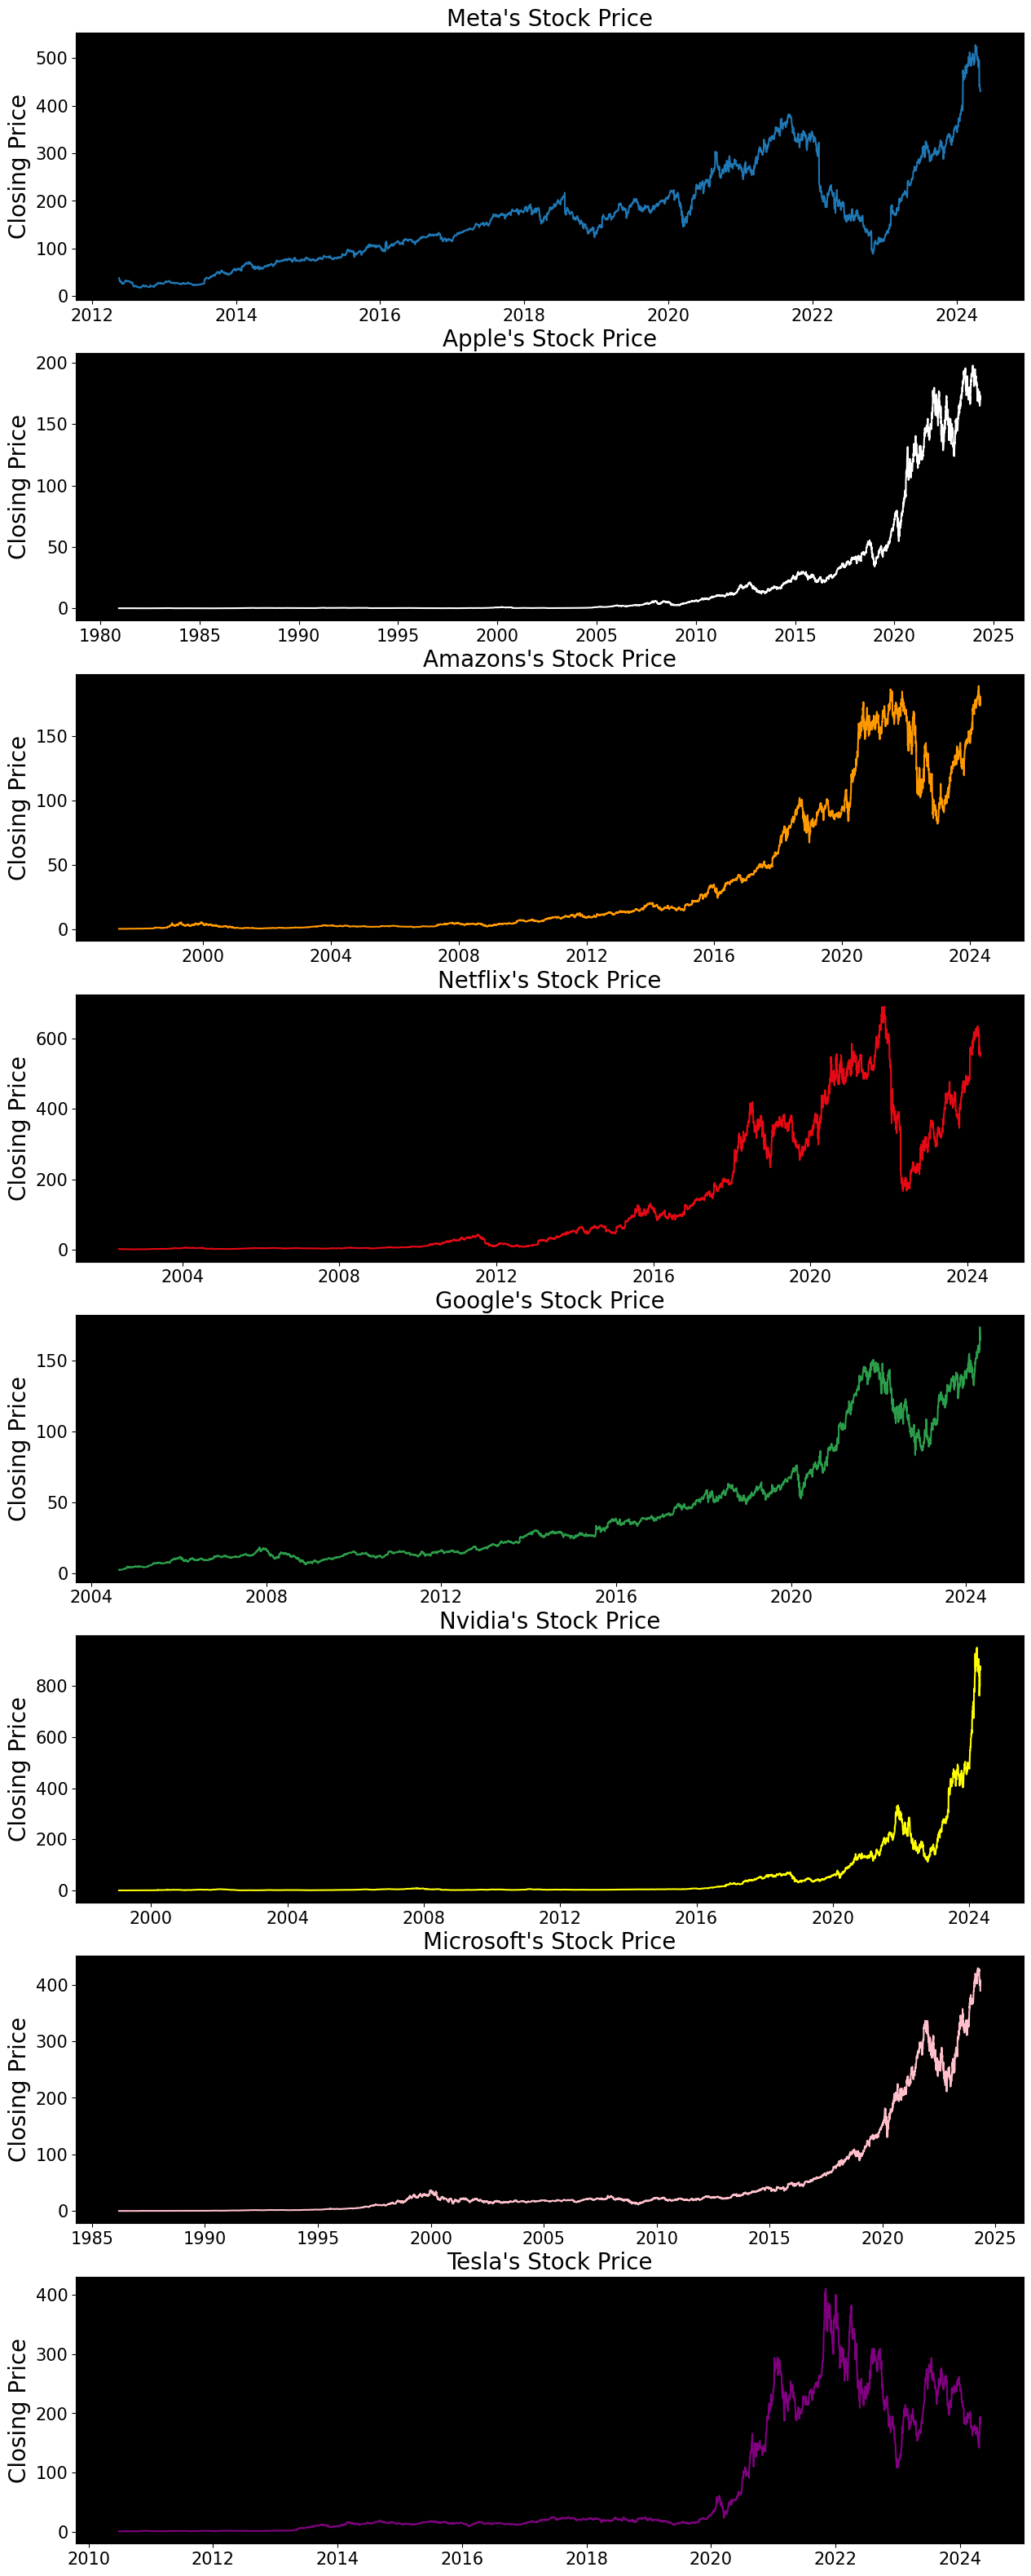

In [14]:
def visualize_bigtech_stock_prices(df_meta, df_aapl, df_amzn, df_nflx, df_goog, df_nvda, df_msft, df_tsla):

    fig, axes = plt.subplots(8, 1, figsize = (15, 40))

    axes[0].set_facecolor('black')
    axes[0].plot(df_meta['Date'], df_meta['Close'])
    axes[0].set_title("Meta's Stock Price", fontsize = 20)
#     axes[0].set_xlabel('Time', fontsize = 20)
    axes[0].set_ylabel('Closing Price', fontsize = 20)
    axes[0].xaxis.set_tick_params(labelsize = 15)
    axes[0].yaxis.set_tick_params(labelsize = 15)
    
    axes[1].set_facecolor('black')
    axes[1].plot(df_aapl['Date'], df_aapl['Close'], color = 'white')
    axes[1].set_title("Apple's Stock Price", fontsize = 20)
#     axes[1].set_xlabel('Time', fontsize = 20)
    axes[1].set_ylabel('Closing Price', fontsize = 20)
    axes[1].xaxis.set_tick_params(labelsize = 15)
    axes[1].yaxis.set_tick_params(labelsize = 15)

    axes[2].set_facecolor('black')
    axes[2].plot(df_amzn['Date'], df_amzn['Close'], color = '#FF9900')
    axes[2].set_title("Amazons's Stock Price", fontsize = 20)
#     axes[2].set_xlabel('Time', fontsize = 20)
    axes[2].set_ylabel('Closing Price', fontsize = 20)
    axes[2].xaxis.set_tick_params(labelsize = 15)
    axes[2].yaxis.set_tick_params(labelsize = 15)

    axes[3].set_facecolor('black')
    axes[3].plot(df_nflx['Date'], df_nflx['Close'], color = '#E50913')
    axes[3].set_title("Netflix's Stock Price", fontsize = 20)
#     axes[3].set_xlabel('Time', fontsize = 20)
    axes[3].set_ylabel('Closing Price', fontsize = 20)
    axes[3].xaxis.set_tick_params(labelsize = 15)
    axes[3].yaxis.set_tick_params(labelsize = 15)

    axes[4].set_facecolor('black')
    axes[4].plot(df_goog['Date'], df_goog['Close'], color = '#2B9D4A')
    axes[4].set_title("Google's Stock Price", fontsize = 20)
#     axes[4].set_xlabel('Time', fontsize = 20)
    axes[4].set_ylabel('Closing Price', fontsize = 20)
    axes[4].xaxis.set_tick_params(labelsize = 15)
    axes[4].yaxis.set_tick_params(labelsize = 15)
    
    axes[5].set_facecolor('black')
    axes[5].plot(df_nvda['Date'], df_nvda['Close'], color = 'yellow')
    axes[5].set_title("Nvidia's Stock Price", fontsize = 20)
#     axes[5].set_xlabel('Time', fontsize = 20)
    axes[5].set_ylabel('Closing Price', fontsize = 20)
    axes[5].xaxis.set_tick_params(labelsize = 15)
    axes[5].yaxis.set_tick_params(labelsize = 15)

    axes[6].set_facecolor('black')
    axes[6].plot(df_msft['Date'], df_msft['Close'], color = 'pink')
    axes[6].set_title("Microsoft's Stock Price", fontsize = 20)
#     axes[6].set_xlabel('Time', fontsize = 20)
    axes[6].set_ylabel('Closing Price', fontsize = 20)
    axes[6].xaxis.set_tick_params(labelsize = 15)
    axes[6].yaxis.set_tick_params(labelsize = 15)
    
    axes[7].set_facecolor('black')
    axes[7].plot(df_tsla['Date'], df_tsla['Close'], color = 'purple')
    axes[7].set_title("Tesla's Stock Price", fontsize = 20)
#     axes[7].set_xlabel('Time', fontsize = 20)
    axes[7].set_ylabel('Closing Price', fontsize = 20)
    axes[7].xaxis.set_tick_params(labelsize = 15)
    axes[7].yaxis.set_tick_params(labelsize = 15)

    plt.show()
    
visualize_bigtech_stock_prices(df_meta, df_aapl, df_amzn, df_nflx, df_goog, df_nvda, df_msft, df_tsla)

**Insights**: We initiate our examination with the Closing Price of the companies. The closing price represents the final price at which a stock is traded during a standard trading session. It is widely regarded as the benchmark by investors for monitoring a stock's performance over a period. From the graphs, it's evident that the closing price for all the stocks has notably declined from 2020 to 2022. This downturn is largely ascribed to the COVID-19 pandemic, which triggered a significant crash in the stock market.

**Insights**: An OHLC (Open, High, Low, Close) chart is commonly utilized to depict the price fluctuations of a financial instrument over time. Each vertical line in the chart represents the range of prices (highest and lowest) across a single time unit. Analogous to the graph of Closing Prices, a substantial decrease is noticeable in the OHLC charts from 2020 to 2022, a phenomenon attributable to the worldwide pandemic.

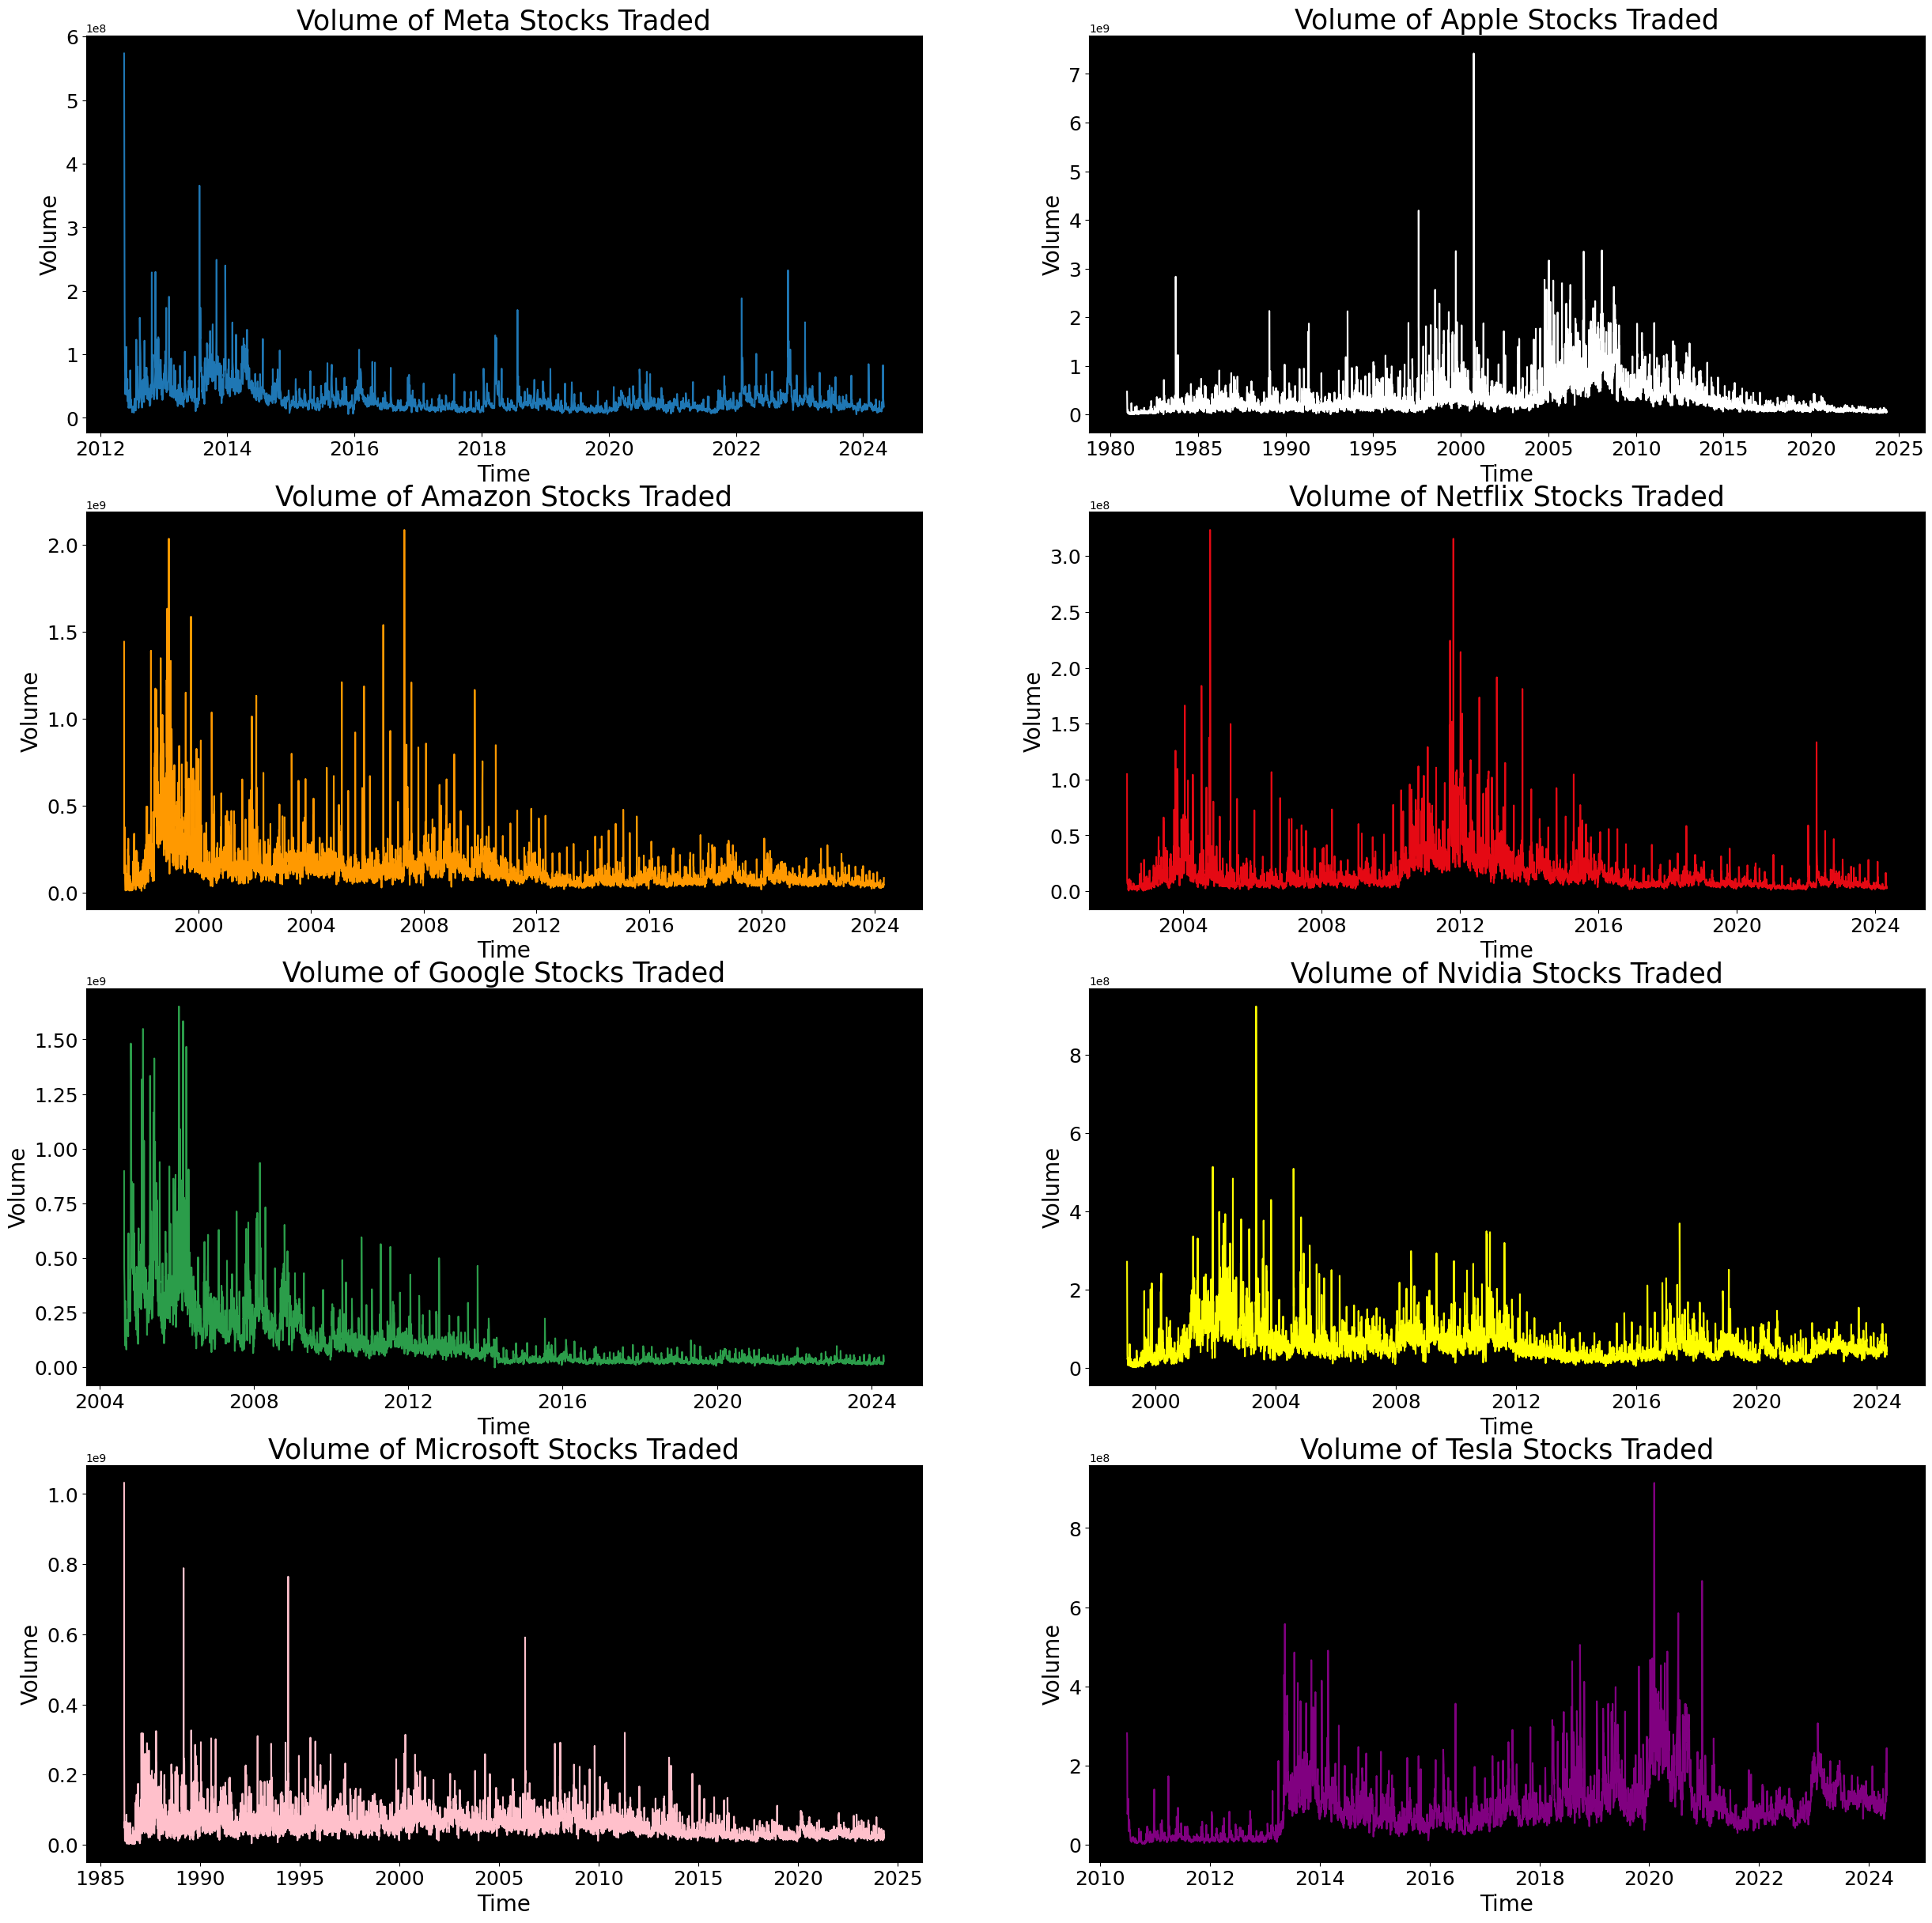

In [15]:
def visualize_bigtech_stock_volume(df_meta, df_aapl, df_amzn, df_nflx, df_goog, df_nvda, df_msft, df_tsla):

    fig, axes = plt.subplots(4, 2, figsize = (30, 30))

    axes[0][0].set_facecolor('black')
    axes[0][0].plot(df_meta['Date'], df_meta['Volume'])
    axes[0][0].set_title("Volume of Meta Stocks Traded", fontsize = 25)
    axes[0][0].set_xlabel('Time', fontsize = 20)
    axes[0][0].set_ylabel('Volume', fontsize = 20)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(df_aapl['Date'], df_aapl['Volume'], color = 'white')
    axes[0][1].set_title("Volume of Apple Stocks Traded", fontsize = 25)
    axes[0][1].set_xlabel('Time', fontsize = 20)
    axes[0][1].set_ylabel('Volume', fontsize = 20)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)

    axes[1][0].set_facecolor('black')
    axes[1][0].plot(df_amzn['Date'], df_amzn['Volume'], color = '#FF9900')
    axes[1][0].set_title("Volume of Amazon Stocks Traded", fontsize = 25)
    axes[1][0].set_xlabel('Time', fontsize = 20)
    axes[1][0].set_ylabel('Volume', fontsize = 20)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)

    axes[1][1].set_facecolor('black')
    axes[1][1].plot(df_nflx['Date'], df_nflx['Volume'], color = '#E50913')
    axes[1][1].set_title("Volume of Netflix Stocks Traded", fontsize = 25)
    axes[1][1].set_xlabel('Time', fontsize = 20)
    axes[1][1].set_ylabel('Volume', fontsize = 20)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)

    axes[2][0].set_facecolor('black')
    axes[2][0].plot(df_goog['Date'], df_goog['Volume'], color = '#2B9D4A')
    axes[2][0].set_title("Volume of Google Stocks Traded", fontsize = 25)
    axes[2][0].set_xlabel('Time', fontsize = 20)
    axes[2][0].set_ylabel('Volume', fontsize = 20)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
    
    axes[2][1].set_facecolor('black')
    axes[2][1].plot(df_nvda['Date'], df_nvda['Volume'], color = 'yellow')
    axes[2][1].set_title("Volume of Nvidia Stocks Traded", fontsize = 25)
    axes[2][1].set_xlabel('Time', fontsize = 20)
    axes[2][1].set_ylabel('Volume', fontsize = 20)
    axes[2][1].xaxis.set_tick_params(labelsize = 18)
    axes[2][1].yaxis.set_tick_params(labelsize = 18)

    axes[3][0].set_facecolor('black')
    axes[3][0].plot(df_msft['Date'], df_msft['Volume'], color = 'pink')
    axes[3][0].set_title("Volume of Microsoft Stocks Traded", fontsize = 25)
    axes[3][0].set_xlabel('Time', fontsize = 20)
    axes[3][0].set_ylabel('Volume', fontsize = 20)
    axes[3][0].xaxis.set_tick_params(labelsize = 18)
    axes[3][0].yaxis.set_tick_params(labelsize = 18)
    
    axes[3][1].set_facecolor('black')
    axes[3][1].plot(df_tsla['Date'], df_tsla['Volume'], color = 'purple')
    axes[3][1].set_title("Volume of Tesla Stocks Traded", fontsize = 25)
    axes[3][1].set_xlabel('Time', fontsize = 20)
    axes[3][1].set_ylabel('Volume', fontsize = 20)
    axes[3][1].xaxis.set_tick_params(labelsize = 18)
    axes[3][1].yaxis.set_tick_params(labelsize = 18)

    plt.show()
    
visualize_bigtech_stock_volume(df_meta, df_aapl, df_amzn, df_nflx, df_goog, df_nvda, df_msft, df_tsla)

**Insights**: The volume of a stock indicates the quantity of its shares that have been traded. There isn't a distinct trend discernible regarding the stock's volume. For certain corporations, like Meta and Google, it's noticeable that the trading volume of the stock at the time of the company's initial public offering was higher compared to the current trading volume. This can be attributed to the stock's price appreciation over time.

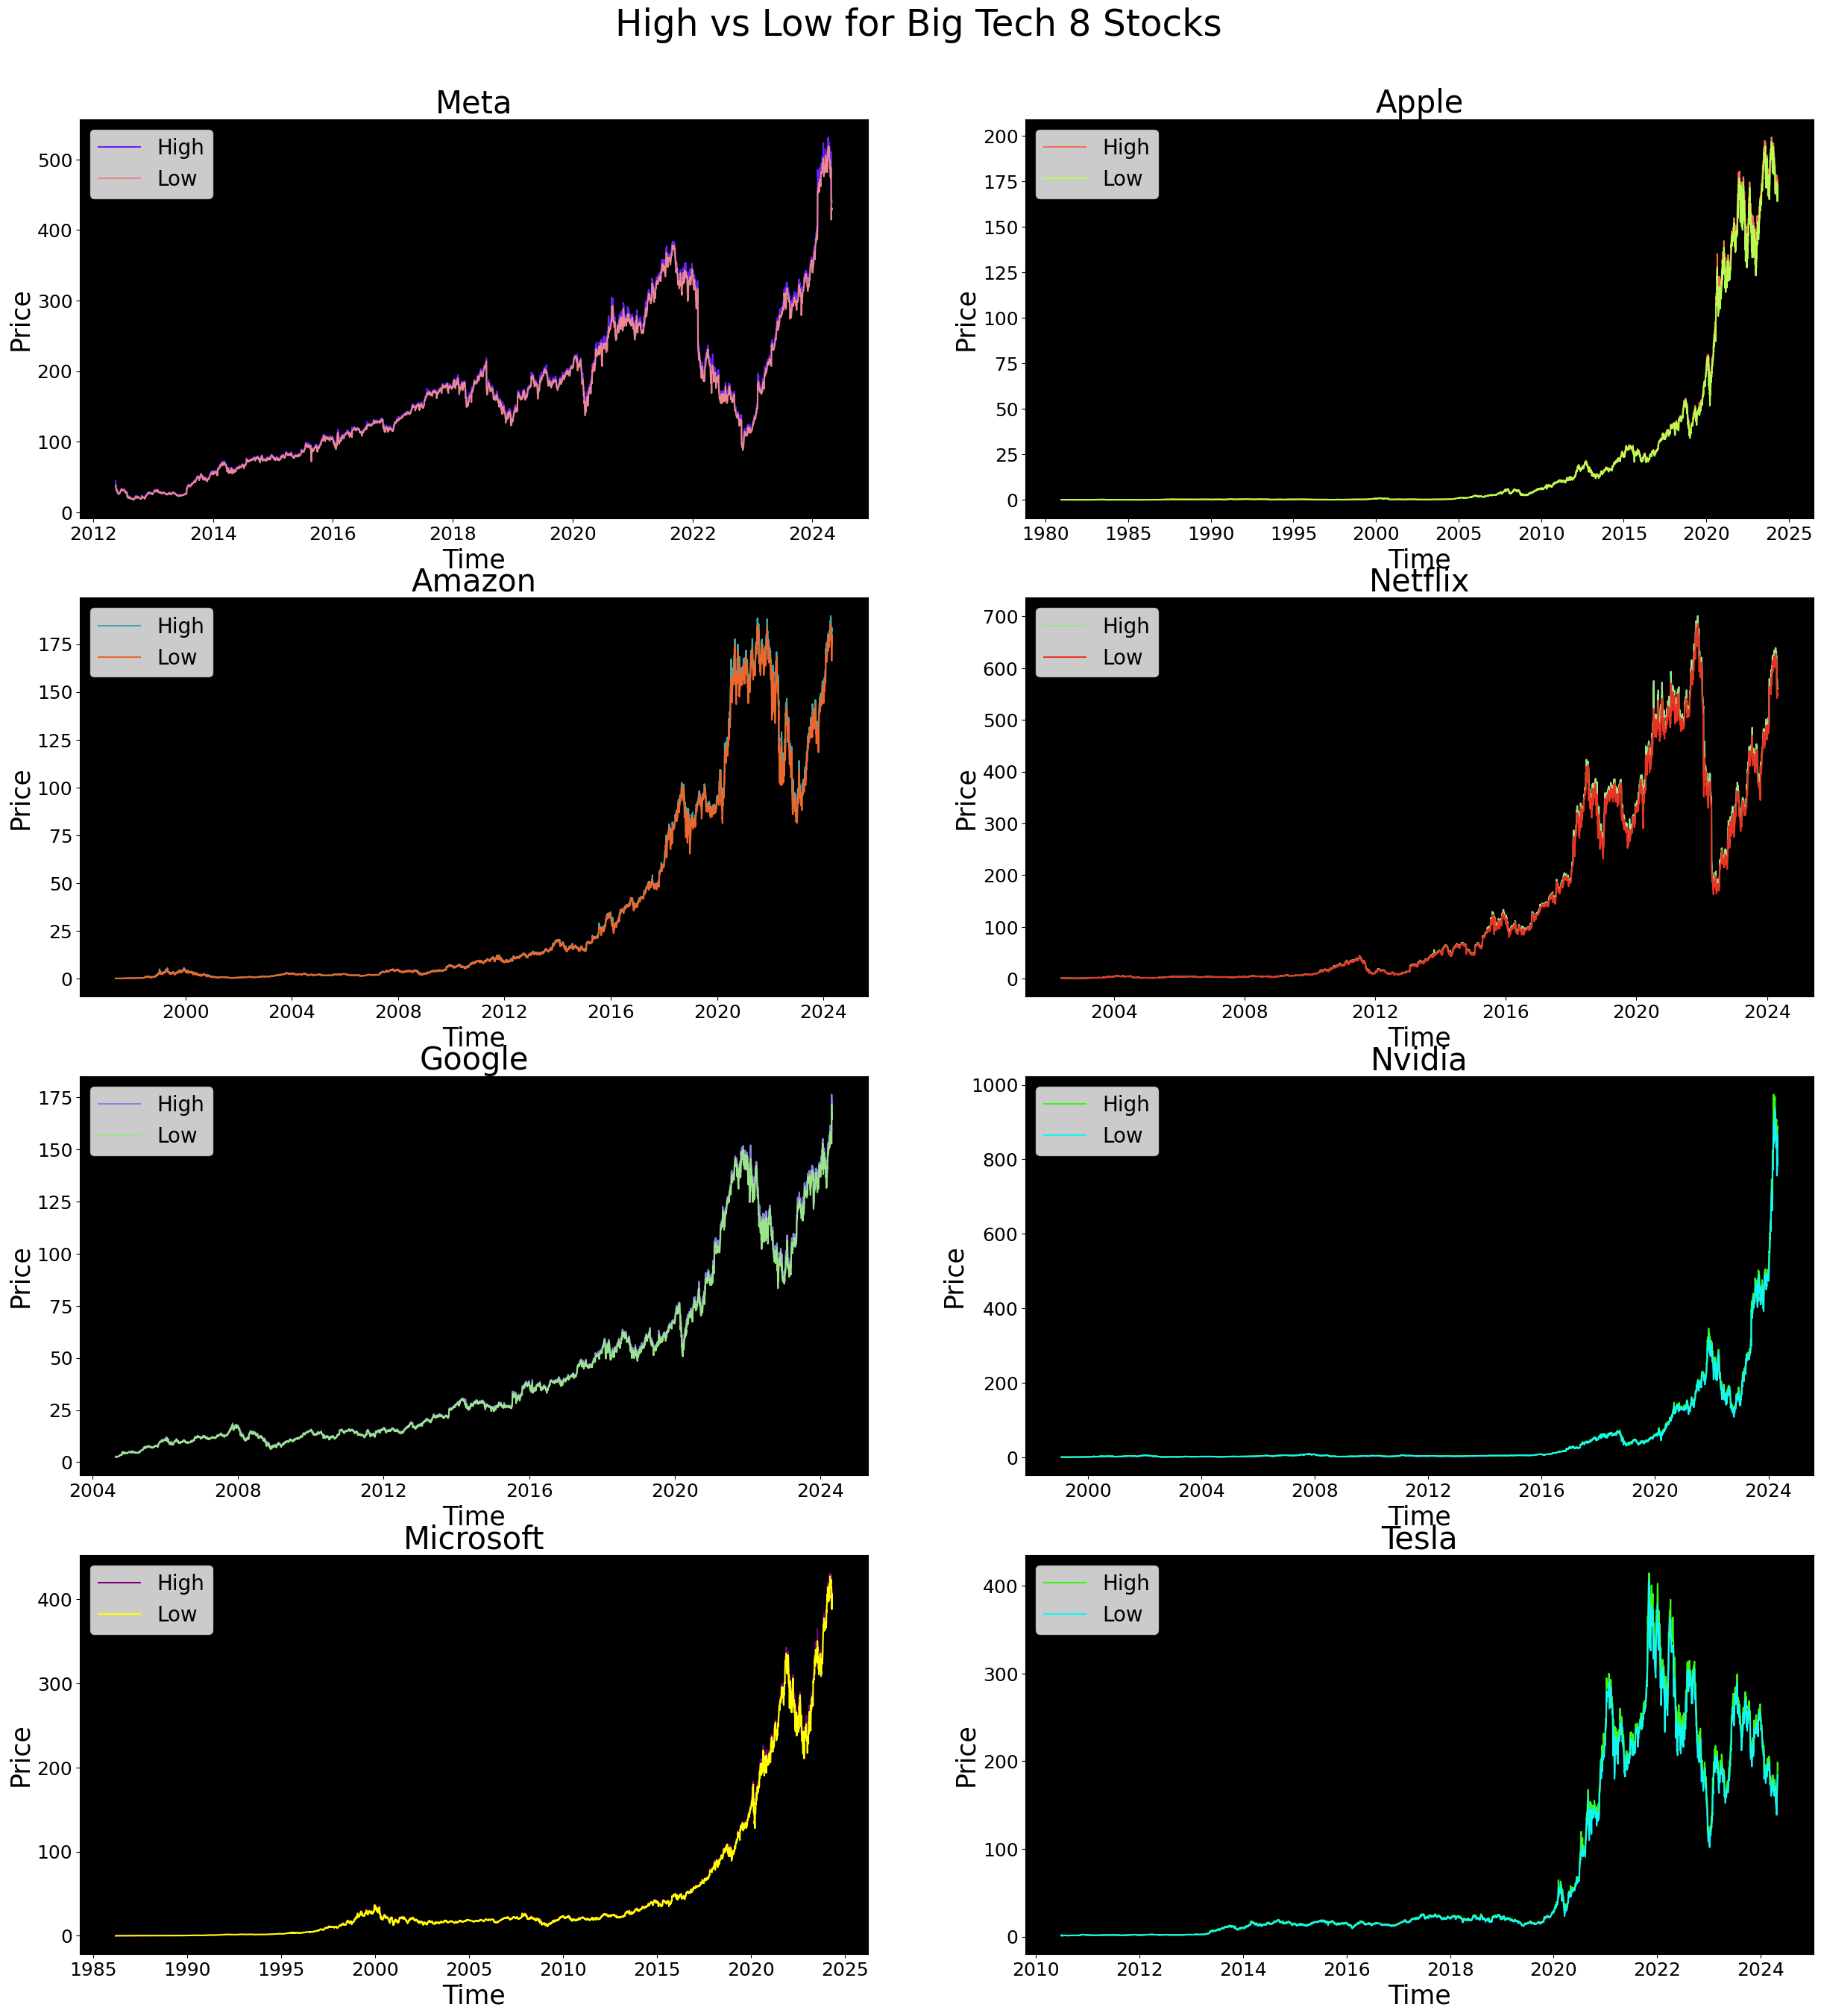

In [16]:
def visualize_bigtech_two_features_over_time_graph(df_meta, df_aapl, df_amzn, df_nflx, df_goog, df_nvda, df_msft, df_tsla, time, feature1, feature2):
    
    fig, axes = plt.subplots(4, 2, figsize = (30, 30))
    
    plt.suptitle(feature1 + ' vs ' + feature2 + ' for Big Tech 8 Stocks', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)

    axes[0][0].set_facecolor('black')
    axes[0][0].plot(df_meta[time], df_meta[feature1], color = '#6522F5', label = feature1)
    axes[0][0].plot(df_meta[time], df_meta[feature2], color = '#EB8791', label = feature2)
    axes[0][0].set_title('Meta', fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Price', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
    axes[0][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(df_aapl[time], df_aapl[feature1], color = '#F26E55', label = feature1)
    axes[0][1].plot(df_aapl[time], df_aapl[feature2], color = '#B9FB50', label = feature2)
    axes[0][1].set_title('Apple', fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Price', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
    axes[0][1].legend(loc = 'upper left', fontsize = 20)
    
    axes[1][0].set_facecolor('black')
    axes[1][0].plot(df_amzn[time], df_amzn[feature1], color = '#47A5A8', label = feature1)
    axes[1][0].plot(df_amzn[time], df_amzn[feature2], color = '#ED672C', label = feature2)
    axes[1][0].set_title('Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Price', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
    axes[1][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[1][1].set_facecolor('black')
    axes[1][1].plot(df_nflx[time], df_nflx[feature1], color = '#9BE48B', label = feature1)
    axes[1][1].plot(df_nflx[time], df_nflx[feature2], color = '#EB3323', label = feature2)
    axes[1][1].set_title('Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Price', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
    axes[1][1].legend(loc = 'upper left', fontsize = 20)
    
    axes[2][0].set_facecolor('black')
    axes[2][0].plot(df_goog[time], df_goog[feature1], color = '#8783E3', label = feature1)
    axes[2][0].plot(df_goog[time], df_goog[feature2], color = '#9BE48B', label = feature2)
    axes[2][0].set_title('Google', fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Price', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
    axes[2][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[2][1].set_facecolor('black')
    axes[2][1].plot(df_nvda[time], df_nvda[feature1], color = '#37f713', label = feature1)
    axes[2][1].plot(df_nvda[time], df_nvda[feature2], color = '#13f7f3', label = feature2)
    axes[2][1].set_title('Nvidia', fontsize = 30)
    axes[2][1].set_xlabel('Time', fontsize = 25)
    axes[2][1].set_ylabel('Price', fontsize = 25)
    axes[2][1].xaxis.set_tick_params(labelsize = 18)
    axes[2][1].yaxis.set_tick_params(labelsize = 18)
    axes[2][1].legend(loc = 'upper left', fontsize = 20)

    axes[3][0].set_facecolor('black')
    axes[3][0].plot(df_msft[time], df_msft[feature1], color = 'purple', label = feature1)
    axes[3][0].plot(df_msft[time], df_msft[feature2], color = 'yellow', label = feature2)
    axes[3][0].set_title('Microsoft', fontsize = 30)
    axes[3][0].set_xlabel('Time', fontsize = 25)
    axes[3][0].set_ylabel('Price', fontsize = 25)
    axes[3][0].xaxis.set_tick_params(labelsize = 18)
    axes[3][0].yaxis.set_tick_params(labelsize = 18)
    axes[3][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[3][1].set_facecolor('black')
    axes[3][1].plot(df_tsla[time], df_tsla[feature1], color = '#37f713', label = feature1)
    axes[3][1].plot(df_tsla[time], df_tsla[feature2], color = '#13f7f3', label = feature2)
    axes[3][1].set_title('Tesla', fontsize = 30)
    axes[3][1].set_xlabel('Time', fontsize = 25)
    axes[3][1].set_ylabel('Price', fontsize = 25)
    axes[3][1].xaxis.set_tick_params(labelsize = 18)
    axes[3][1].yaxis.set_tick_params(labelsize = 18)
    axes[3][1].legend(loc = 'upper left', fontsize = 20)


    plt.subplots_adjust(top = 0.93)
    plt.show()
    
visualize_bigtech_two_features_over_time_graph(df_meta, df_aapl, df_amzn, df_nflx, df_goog, df_nvda, df_msft, df_tsla, 'Date', 'High', 'Low')

**Insights**: The "high" represents the maximum price a stock reaches during a given period, while the "low" denotes its minimum price during the same timeframe. These peaks and troughs within a day are referred to as the stock's intraday high and low. The High and Low values of the stocks tend to coincide, suggesting that the daily range between the Highs and Lows was relatively consistent. However, there are instances where the High value significantly exceeds the Low, which might signal a bullish market trend.

In [17]:
candlestick_chart_data = ['Date', 'Open', 'High', 'Low', 'Close']
new_meta_df = df_meta[candlestick_chart_data]
new_aapl_df = df_aapl[candlestick_chart_data]
new_amzn_df = df_amzn[candlestick_chart_data]
new_nflx_df = df_nflx[candlestick_chart_data]
new_goog_df = df_goog[candlestick_chart_data]
new_nvda_df = df_nvda[candlestick_chart_data]
new_msft_df = df_msft[candlestick_chart_data]
new_tsla_df = df_tsla[candlestick_chart_data]

def create_moving_averages_columns(company_data):
    days_for_moving_averages = [10, 50, 100]
    
    for moving_averages in days_for_moving_averages:
        column = f'MA for {moving_averages} days'
        company_data[column] = company_data['Close'].rolling(moving_averages).mean()
        
    return company_data

new_meta_df = create_moving_averages_columns(new_meta_df)
new_aapl_df = create_moving_averages_columns(new_aapl_df)
new_amzn_df = create_moving_averages_columns(new_amzn_df)
new_nflx_df = create_moving_averages_columns(new_nflx_df)
new_goog_df = create_moving_averages_columns(new_goog_df)
new_nvda_df = create_moving_averages_columns(new_nvda_df)
new_msft_df = create_moving_averages_columns(new_msft_df)
new_tsla_df = create_moving_averages_columns(new_tsla_df)

new_meta_df.tail(10)

,Date,Open,High,Low,Close,MA for 10 days,MA for 50 days,MA for 100 days
2996,2024-04-17 00:00:00-04:00,503.100006,503.160004,487.140015,494.170013,512.346008,492.862101,425.971056
2997,2024-04-18 00:00:00-04:00,499.820007,512.210022,499.040009,501.799988,511.434006,493.813340,427.577776
2998,2024-04-19 00:00:00-04:00,502.799988,502.799988,475.730011,481.070007,506.807004,494.052894,429.009760
2999,2024-04-22 00:00:00-04:00,489.720001,492.010010,473.399994,481.730011,503.055005,494.297457,430.483608
3000,2024-04-23 00:00:00-04:00,491.250000,498.760010,488.970001,496.100006,500.975003,494.867181,432.058301
3001,2024-04-24 00:00:00-04:00,508.059998,510.000000,484.579987,493.500000,498.342001,495.369120,433.674821
3002,2024-04-25 00:00:00-04:00,421.399994,445.769989,414.500000,441.380005,490.164005,495.004074,434.820589
3003,2024-04-26 00:00:00-04:00,441.459991,446.440002,431.959991,443.290009,483.303006,494.414307,436.008732
3004,2024-04-29 00:00:00-04:00,439.559998,439.760010,428.559998,432.619995,476.542004,493.396367,437.138123
3005,2024-04-30 00:00:00-04:00,431.029999,439.600006,429.720001,430.170013,469.583005,492.543401,438.260297


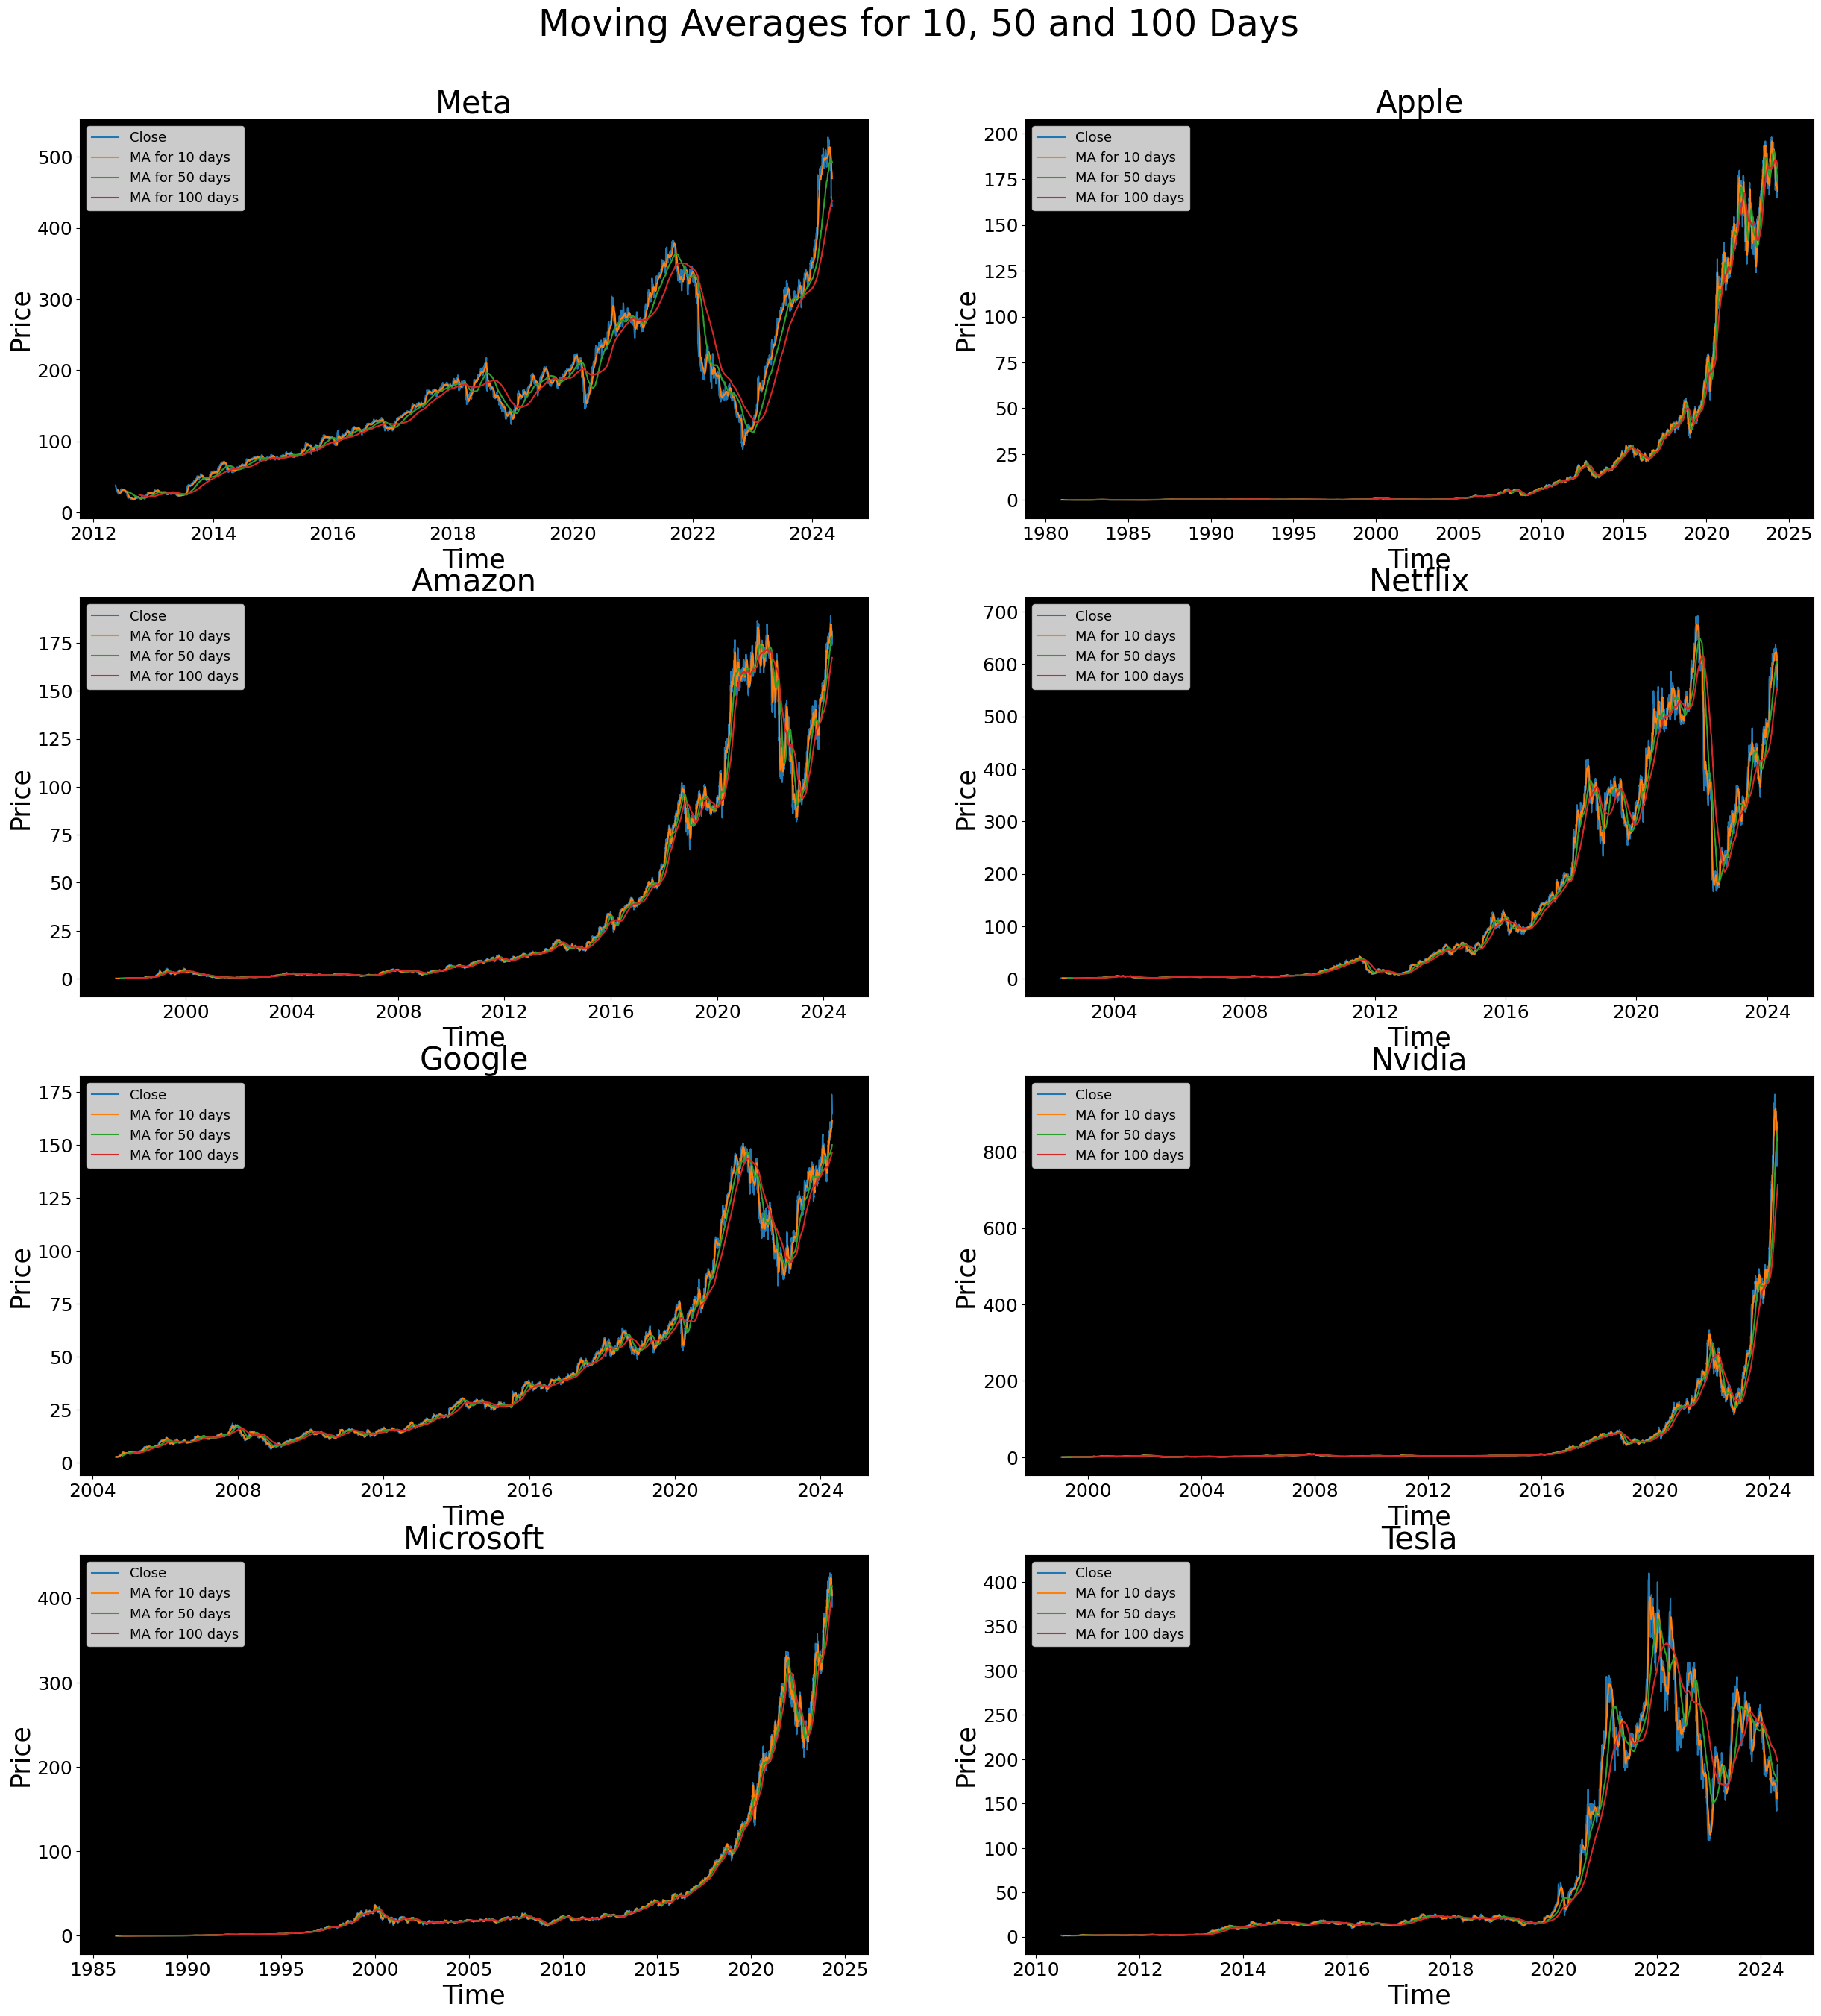

In [18]:
def visualize_moving_averages(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df, new_nvda_df, new_msft_df, new_tsla_df, time, feature, ma1, ma2, ma3):

    fig, axes = plt.subplots(4, 2, figsize = (30, 30))

    plt.suptitle('Moving Averages for 10, 50 and 100 Days', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)

    axes[0][0].set_facecolor('black')
    axes[0][0].plot(new_meta_df[time], new_meta_df[feature], label = feature)
    axes[0][0].plot(new_meta_df[time], new_meta_df[ma1], label = ma1)
    axes[0][0].plot(new_meta_df[time], new_meta_df[ma2], label = ma2)
    axes[0][0].plot(new_meta_df[time], new_meta_df[ma3], label = ma3)
    axes[0][0].set_title('Meta', fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Price', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
    axes[0][0].legend(loc = 'upper left', fontsize = 13)
    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(new_aapl_df[time], new_aapl_df[feature], label = feature)
    axes[0][1].plot(new_aapl_df[time], new_aapl_df[ma1], label = ma1)
    axes[0][1].plot(new_aapl_df[time], new_aapl_df[ma2], label = ma2)
    axes[0][1].plot(new_aapl_df[time], new_aapl_df[ma3], label = ma3)
    axes[0][1].set_title('Apple', fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Price', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
    axes[0][1].legend(loc = 'upper left', fontsize = 13)
    
    axes[1][0].set_facecolor('black')
    axes[1][0].plot(new_amzn_df[time], new_amzn_df[feature], label = feature)
    axes[1][0].plot(new_amzn_df[time], new_amzn_df[ma1], label = ma1)
    axes[1][0].plot(new_amzn_df[time], new_amzn_df[ma2], label = ma2)
    axes[1][0].plot(new_amzn_df[time], new_amzn_df[ma3], label = ma3)
    axes[1][0].set_title('Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Price', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
    axes[1][0].legend(loc = 'upper left', fontsize = 13)
    
    axes[1][1].set_facecolor('black')
    axes[1][1].plot(new_nflx_df[time], new_nflx_df[feature], label = feature)
    axes[1][1].plot(new_nflx_df[time], new_nflx_df[ma1], label = ma1)
    axes[1][1].plot(new_nflx_df[time], new_nflx_df[ma2], label = ma2)
    axes[1][1].plot(new_nflx_df[time], new_nflx_df[ma3], label = ma3)
    axes[1][1].set_title('Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Price', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
    axes[1][1].legend(loc = 'upper left', fontsize = 13)
    
    axes[2][0].set_facecolor('black')
    axes[2][0].plot(new_goog_df[time], new_goog_df[feature], label = feature)
    axes[2][0].plot(new_goog_df[time], new_goog_df[ma1], label = ma1)
    axes[2][0].plot(new_goog_df[time], new_goog_df[ma2], label = ma2)
    axes[2][0].plot(new_goog_df[time], new_goog_df[ma3], label = ma3)
    axes[2][0].set_title('Google', fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Price', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
    axes[2][0].legend(loc = 'upper left', fontsize = 13)
    
    axes[2][1].set_facecolor('black')
    axes[2][1].plot(new_nvda_df[time], new_nvda_df[feature], label = feature)
    axes[2][1].plot(new_nvda_df[time], new_nvda_df[ma1], label = ma1)
    axes[2][1].plot(new_nvda_df[time], new_nvda_df[ma2], label = ma2)
    axes[2][1].plot(new_nvda_df[time], new_nvda_df[ma3], label = ma3)
    axes[2][1].set_title('Nvidia', fontsize = 30)
    axes[2][1].set_xlabel('Time', fontsize = 25)
    axes[2][1].set_ylabel('Price', fontsize = 25)
    axes[2][1].xaxis.set_tick_params(labelsize = 18)
    axes[2][1].yaxis.set_tick_params(labelsize = 18)
    axes[2][1].legend(loc = 'upper left', fontsize = 13)

    axes[3][0].set_facecolor('black')
    axes[3][0].plot(new_msft_df[time], new_msft_df[feature], label = feature)
    axes[3][0].plot(new_msft_df[time], new_msft_df[ma1], label = ma1)
    axes[3][0].plot(new_msft_df[time], new_msft_df[ma2], label = ma2)
    axes[3][0].plot(new_msft_df[time], new_msft_df[ma3], label = ma3)
    axes[3][0].set_title('Microsoft', fontsize = 30)
    axes[3][0].set_xlabel('Time', fontsize = 25)
    axes[3][0].set_ylabel('Price', fontsize = 25)
    axes[3][0].xaxis.set_tick_params(labelsize = 18)
    axes[3][0].yaxis.set_tick_params(labelsize = 18)
    axes[3][0].legend(loc = 'upper left', fontsize = 13)
    
    axes[3][1].set_facecolor('black')
    axes[3][1].plot(new_tsla_df[time], new_tsla_df[feature], label = feature)
    axes[3][1].plot(new_tsla_df[time], new_tsla_df[ma1], label = ma1)
    axes[3][1].plot(new_tsla_df[time], new_tsla_df[ma2], label = ma2)
    axes[3][1].plot(new_tsla_df[time], new_tsla_df[ma3], label = ma3)
    axes[3][1].set_title('Tesla', fontsize = 30)
    axes[3][1].set_xlabel('Time', fontsize = 25)
    axes[3][1].set_ylabel('Price', fontsize = 25)
    axes[3][1].xaxis.set_tick_params(labelsize = 18)
    axes[3][1].yaxis.set_tick_params(labelsize = 18)
    axes[3][1].legend(loc = 'upper left', fontsize = 13)


    plt.subplots_adjust(top = 0.93)
    plt.show()

visualize_moving_averages(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df, new_nvda_df, new_msft_df, new_tsla_df,'Date', 'Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days')

**Insights**: Moving Averages (MA) are one of the most popular and often used technical indicators in financial markets. In simple word, a moving average is an indicator that shows the average value of a stock's price over a period (i.e. 10 days, 50 days, 100 days, etc) and is usually plotted along with the closing price. The most common applications of moving averages are to identify the trending direction and determine support and resistance levels. One can also say that moving averages are used to smoothen out the noise of short-term price fluctuations, so as to be able to identify and define significant underlying trends more readily. When calculating a moving average, a mathematical analysis of the stock's average value over a predetermined time period is made. As the stock price changes, its average price moves up or down.

In [19]:
new_meta_df['Daily Return'] = new_meta_df['Close'].pct_change()
new_aapl_df['Daily Return'] = new_aapl_df['Close'].pct_change()
new_amzn_df['Daily Return'] = new_amzn_df['Close'].pct_change()
new_nflx_df['Daily Return'] = new_nflx_df['Close'].pct_change()
new_goog_df['Daily Return'] = new_goog_df['Close'].pct_change()
new_nvda_df['Daily Return'] = new_nvda_df['Close'].pct_change()
new_msft_df['Daily Return'] = new_msft_df['Close'].pct_change()
new_tsla_df['Daily Return'] = new_tsla_df['Close'].pct_change()
new_meta_df.tail()

,Date,Open,High,Low,Close,MA for 10 days,MA for 50 days,MA for 100 days,Daily Return
3001,2024-04-24 00:00:00-04:00,508.059998,510.000000,484.579987,493.500000,498.342001,495.369120,433.674821,-0.005241
3002,2024-04-25 00:00:00-04:00,421.399994,445.769989,414.500000,441.380005,490.164005,495.004074,434.820589,-0.105613
3003,2024-04-26 00:00:00-04:00,441.459991,446.440002,431.959991,443.290009,483.303006,494.414307,436.008732,0.004327
3004,2024-04-29 00:00:00-04:00,439.559998,439.760010,428.559998,432.619995,476.542004,493.396367,437.138123,-0.024070
3005,2024-04-30 00:00:00-04:00,431.029999,439.600006,429.720001,430.170013,469.583005,492.543401,438.260297,-0.005663


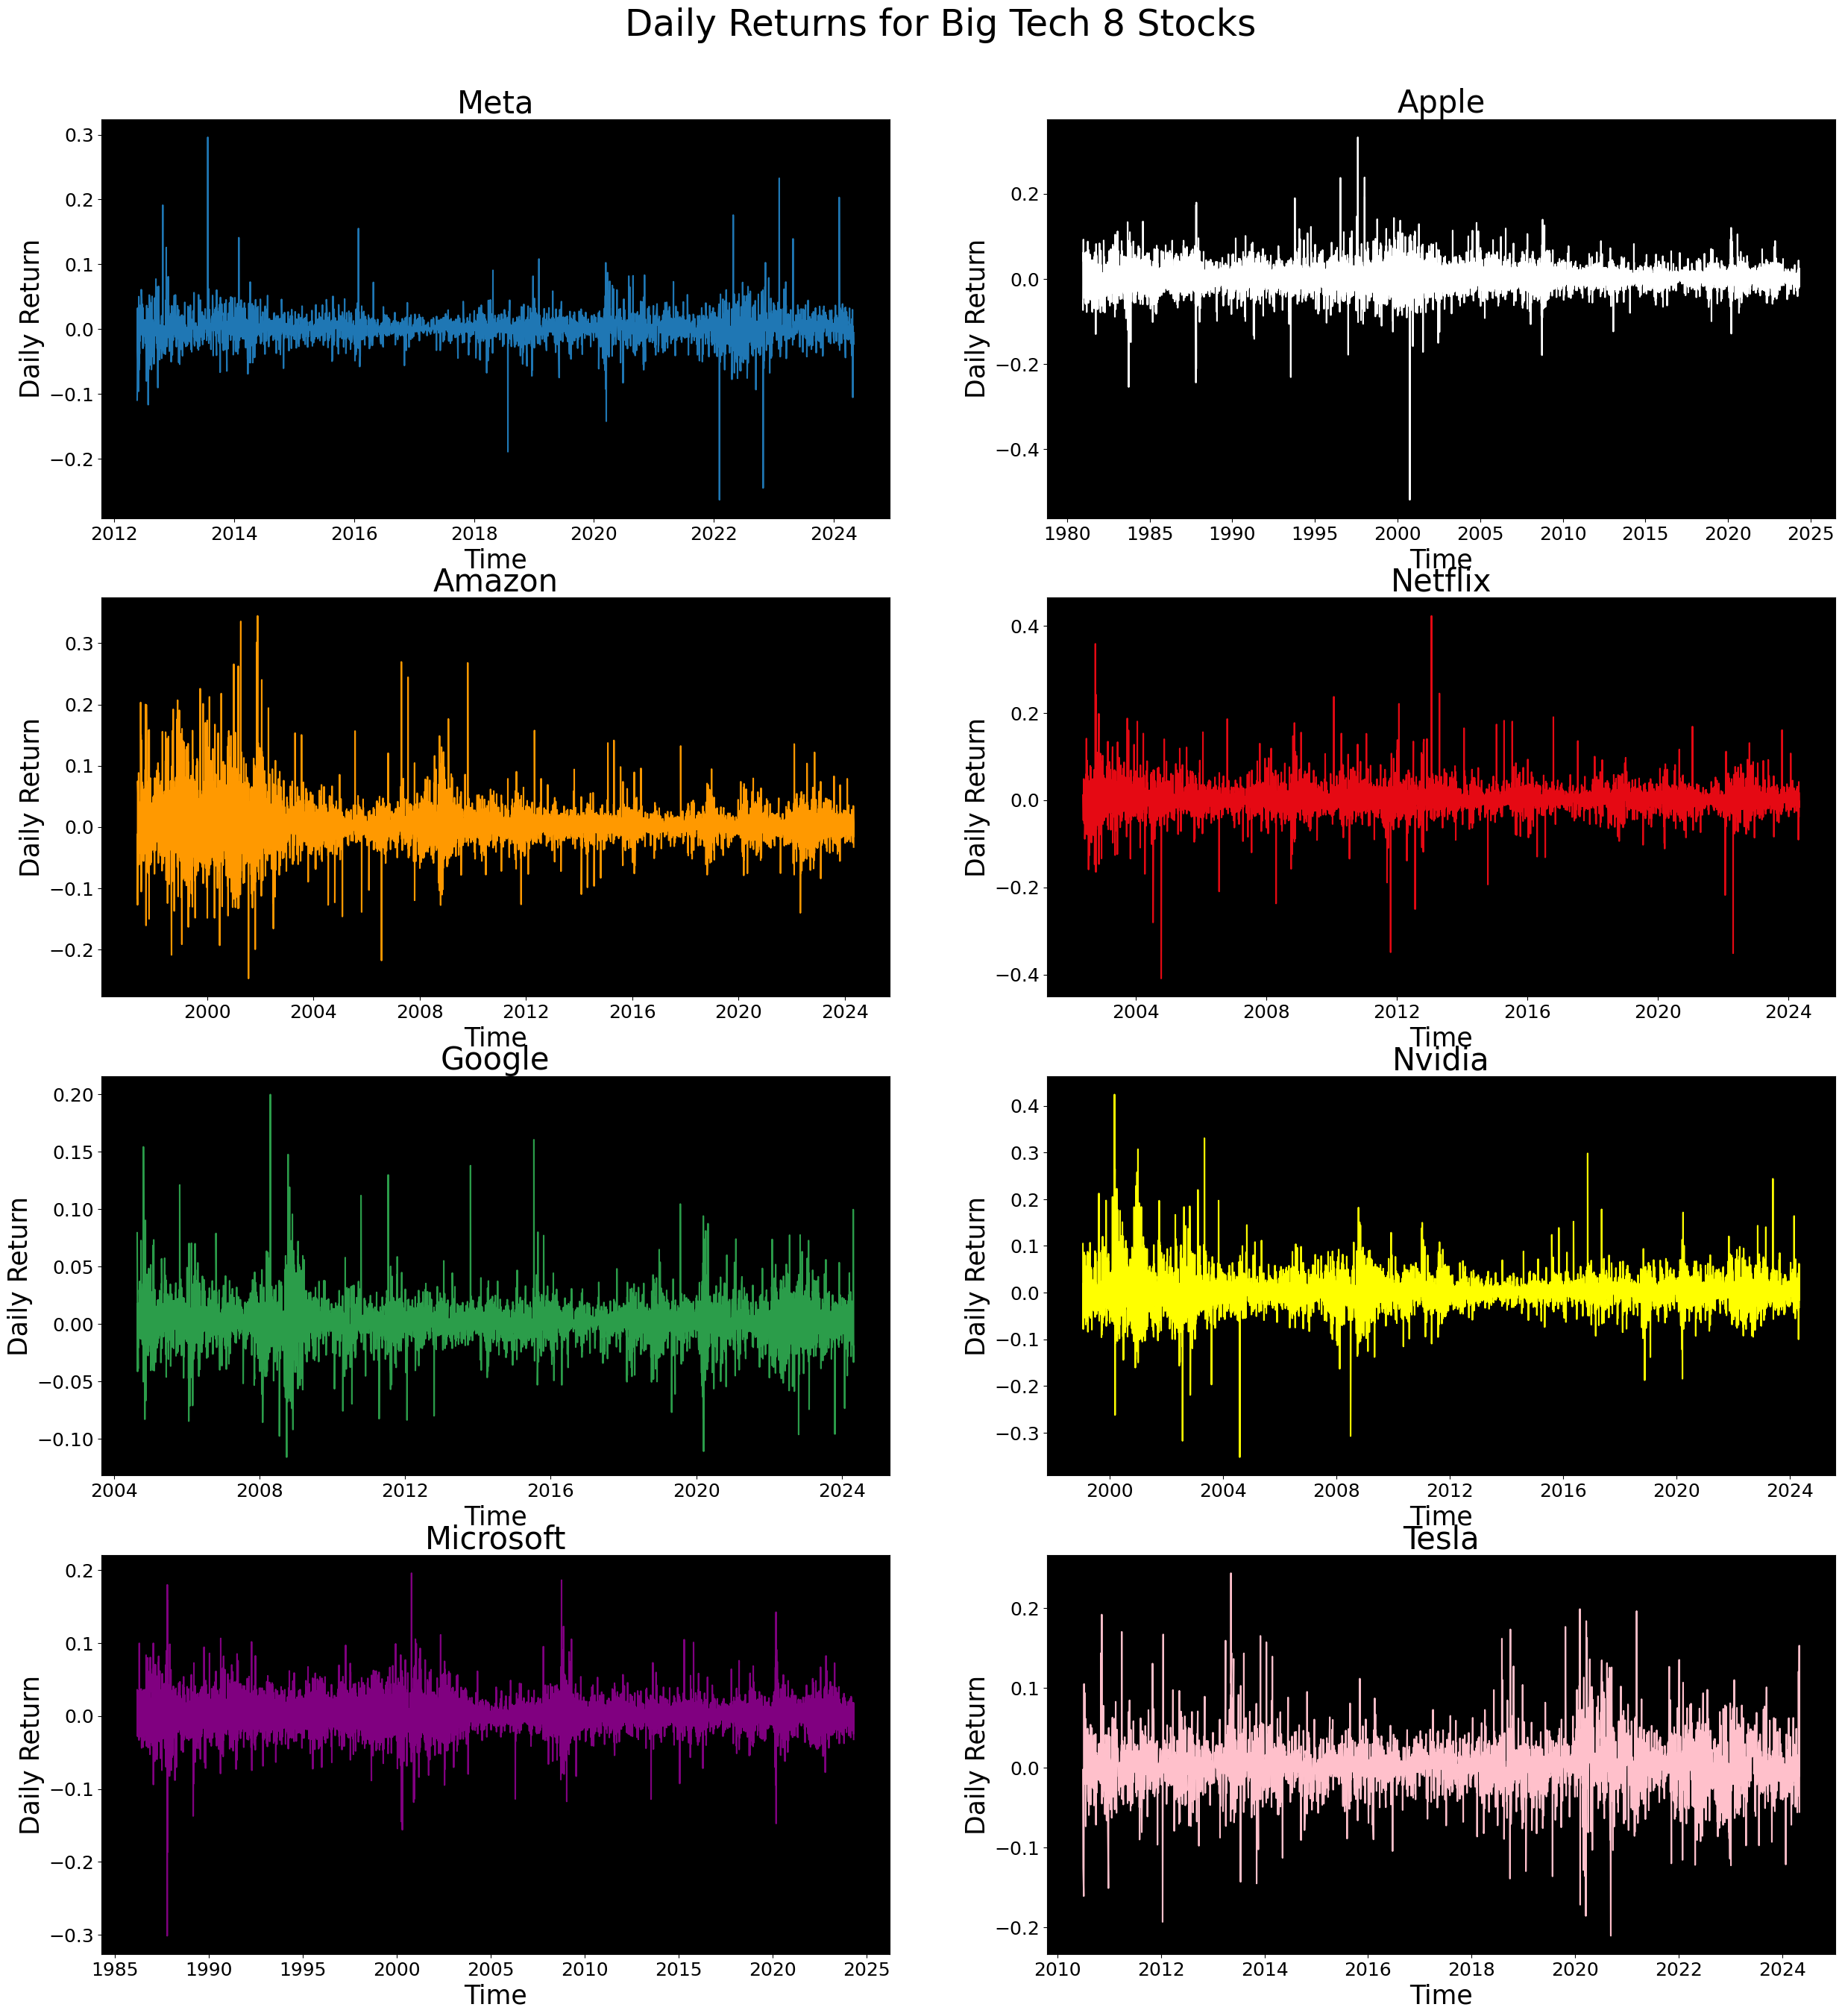

In [20]:
def visualize_faang_daily_return(df_meta, df_aapl, df_amzn, df_nflx, df_goog, df_nvda, df_msft, df_tsla):

    fig, axes = plt.subplots(4, 2, figsize = (30, 30))
    
    plt.suptitle('Daily Returns for Big Tech 8 Stocks', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)

    axes[0][0].set_facecolor('black')
    axes[0][0].plot(df_meta['Date'], df_meta['Daily Return'])
    axes[0][0].set_title('Meta', fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Daily Return', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(df_aapl['Date'], df_aapl['Daily Return'], color = 'white')
    axes[0][1].set_title('Apple', fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Daily Return', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)

    axes[1][0].set_facecolor('black')
    axes[1][0].plot(df_amzn['Date'], df_amzn['Daily Return'], color = '#FF9900')
    axes[1][0].set_title('Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Daily Return', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)

    axes[1][1].set_facecolor('black')
    axes[1][1].plot(df_nflx['Date'], df_nflx['Daily Return'], color = '#E50913')
    axes[1][1].set_title('Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Daily Return', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)

    axes[2][0].set_facecolor('black')
    axes[2][0].plot(df_goog['Date'], df_goog['Daily Return'], color = '#2B9D4A')
    axes[2][0].set_title('Google', fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Daily Return', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
    
    axes[2][1].set_facecolor('black')
    axes[2][1].plot(df_nvda['Date'], df_nvda['Daily Return'], color = 'yellow')
    axes[2][1].set_title('Nvidia', fontsize = 30)
    axes[2][1].set_xlabel('Time', fontsize = 25)
    axes[2][1].set_ylabel('Daily Return', fontsize = 25)
    axes[2][1].xaxis.set_tick_params(labelsize = 18)
    axes[2][1].yaxis.set_tick_params(labelsize = 18)

    axes[3][0].set_facecolor('black')
    axes[3][0].plot(df_msft['Date'], df_msft['Daily Return'], color = 'purple')
    axes[3][0].set_title('Microsoft', fontsize = 30)
    axes[3][0].set_xlabel('Time', fontsize = 25)
    axes[3][0].set_ylabel('Daily Return', fontsize = 25)
    axes[3][0].xaxis.set_tick_params(labelsize = 18)
    axes[3][0].yaxis.set_tick_params(labelsize = 18)
    
    axes[3][1].set_facecolor('black')
    axes[3][1].plot(df_tsla['Date'], df_tsla['Daily Return'], color = 'pink')
    axes[3][1].set_title('Tesla', fontsize = 30)
    axes[3][1].set_xlabel('Time', fontsize = 25)
    axes[3][1].set_ylabel('Daily Return', fontsize = 25)
    axes[3][1].xaxis.set_tick_params(labelsize = 18)
    axes[3][1].yaxis.set_tick_params(labelsize = 18)
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
visualize_faang_daily_return(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df, new_nvda_df, new_msft_df, new_tsla_df)

**Insights**: Daily return on a stock is used to measure the day to day performance of stocks, it is the price of stocks at today’s close compared to the price of the same stock at yesterday’s close. A positive daily return means appreciation in stock price for that particular day. Based on the graphs we plotted for the daily return over time for FAANG stocks, no particular pattern or trend can be observed. All the graphs contain a large number of fluctuations in the data, making it difficult to identify any specific trend in the movement of the stock.

# Predictions Using Bi-LSTMs
LSTM stands for Long Short Term Memory. It is a type of Recurrent Neural Network that is capable of learning long-term dependencies, especially in sequence prediction problems. LSTMs have feedback connections which make them different to more traditional feedforward neural networks. This property enables LSTMs to process entire sequences of data (e.g. time series) without treating each point in the sequence independently, but rather, retaining useful information about previous data in the sequence to help with the processing of new data points.

The output of an LSTM at a particular point in time is dependant on 3 things:

* The current long-term memory of the network, known as the cell state
* The output at the previous point in time, known as the previous hidden state
* The input data at the current time step

LSTMs use a series of gates which control how the information in a sequence of data comes into, is stored in and leaves the network. There are 3 gates in a typical LSTM:

* Forget Gate
* Input Gate
* Output Gate

These gates can be thought of as filters and are each their own neural network. This is what the visual representation of an LSTM looks like:
![nn](BI-LSTM.png)

# Bi-Directional LSTMs
These are like upgraded LSTMs. In Bi-directional LSTMs, our input flows in two directions, making it different from the regular LSTM. With the regular LSTM, we can make input flow in one direction, either backwards or forward. However, in bi-directional, we can make the input flow in both directions to preserve both the future and the past information. This is what a Bi-directional LSTM looks like:
![nn](BI-LSTM2.jpeg)

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
def retrieve_closing_prices_only(data):
    data = data[['Close']]
    return data

def min_max_scaling(data):
    scaler = MinMaxScaler(feature_range = (0, 1))
    data = scaler.fit_transform(data.values)
    return scaler, data
    
meta_scaler, new_meta_df = min_max_scaling(retrieve_closing_prices_only(new_meta_df))
aapl_scaler, new_aapl_df = min_max_scaling(retrieve_closing_prices_only(new_aapl_df))
amzn_scaler, new_amzn_df = min_max_scaling(retrieve_closing_prices_only(new_amzn_df))
nflx_scaler, new_nflx_df = min_max_scaling(retrieve_closing_prices_only(new_nflx_df))
goog_scaler, new_goog_df = min_max_scaling(retrieve_closing_prices_only(new_goog_df))
nvda_scaler, new_nvda_df = min_max_scaling(retrieve_closing_prices_only(new_nvda_df))
msft_scaler, new_msft_df = min_max_scaling(retrieve_closing_prices_only(new_msft_df))
tsla_scaler, new_tsla_df = min_max_scaling(retrieve_closing_prices_only(new_tsla_df))

new_meta_df

array([[0.04018272],
       [0.03195016],
       [0.02601096],
       ...,
       [0.83507601],
       [0.81413918],
       [0.80933179]])

In [23]:
def split_and_reshape_data(dataframe, pred_days, company):
    prediction_days = pred_days
    
    train_size = int(np.ceil(len(dataframe) * 0.95))
    test_size = len(dataframe) - train_size
    print(f'The training size for {company.title()} is {train_size} rows')
    print(f'The testing size for {company.title()} is {test_size} rows')
    
    train_data = dataframe[0: int(train_size), :]
    test_data = dataframe[train_size - prediction_days:, :]
    
    X_train, y_train, X_test, y_test = [], [], [], []
    
    for i in range(prediction_days, len(train_data)):
        X_train.append(train_data[i - prediction_days: i, 0])
        y_train.append(train_data[i, 0])
        
    for i in range(prediction_days, len(test_data)):
        X_test.append(test_data[i - prediction_days: i, 0])
        y_test.append(test_data[i, 0])
        
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
        
    print('Data for {} split successfully'.format(company.title()))
    
    return X_train, y_train, X_test, y_test
    
X_train_meta, y_train_meta, X_test_meta, y_test_meta = split_and_reshape_data(new_meta_df, 30, 'META')
X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl = split_and_reshape_data(new_aapl_df, 30, 'APPLE')
X_train_amzn, y_train_amzn, X_test_amzn, y_test_amzn = split_and_reshape_data(new_amzn_df, 30, 'AMAZON')
X_train_nflx, y_train_nflx, X_test_nflx, y_test_nflx = split_and_reshape_data(new_nflx_df, 30, 'NETFLIX')
X_train_goog, y_train_goog, X_test_goog, y_test_goog = split_and_reshape_data(new_goog_df, 30, 'GOOGLE')
X_train_nvda, y_train_nvda, X_test_nvda, y_test_nvda = split_and_reshape_data(new_nvda_df, 30, 'NVIDIA')
X_train_msft, y_train_msft, X_test_msft, y_test_msft = split_and_reshape_data(new_msft_df, 30, 'MICROSOFT')
X_train_tsla, y_train_tsla, X_test_tsla, y_test_tsla = split_and_reshape_data(new_tsla_df, 30, 'TESLA')

The training size for Meta is 2856 rows
The testing size for Meta is 150 rows
Data for Meta split successfully
The training size for Apple is 10390 rows
The testing size for Apple is 546 rows
Data for Apple split successfully
The training size for Amazon is 6445 rows
The testing size for Amazon is 339 rows
Data for Amazon split successfully
The training size for Netflix is 5246 rows
The testing size for Netflix is 276 rows
Data for Netflix split successfully
The training size for Google is 4711 rows
The testing size for Google is 247 rows
Data for Google split successfully
The training size for Nvidia is 6042 rows
The testing size for Nvidia is 317 rows
Data for Nvidia split successfully
The training size for Microsoft is 9130 rows
The testing size for Microsoft is 480 rows
Data for Microsoft split successfully
The training size for Tesla is 3309 rows
The testing size for Tesla is 174 rows
Data for Tesla split successfully


In [24]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential

In [ ]:
def create_and_train_bilstm_model(X_train, y_train, X_test, y_test, company):
    
    print('=========For {}========='.format(company))
    
    model = Sequential([
    Conv1D(32, 3, strides = 1, activation = 'relu', input_shape = [30, 1]),
    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(64)),
    Dense(32, activation = 'relu'),
    Dense(1)
    ])
    
    model.compile(optimizer = Adam(), loss = Huber(), metrics = ['mse', 'mae'])
    
    predictor = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50)
    
    y_pred = model.predict(X_test)
    
    return model, predictor, y_pred

meta_model, meta_predictor, meta_y_pred = create_and_train_bilstm_model(X_train_meta, y_train_meta, X_test_meta, y_test_meta, 'Meta')
aapl_model, aapl_predictor, aapl_y_pred = create_and_train_bilstm_model(X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl, 'Apple')
amzn_model, amzn_predictor, amzn_y_pred = create_and_train_bilstm_model(X_train_amzn, y_train_amzn, X_test_amzn, y_test_amzn, 'Amazon')
nflx_model, nflx_predictor, nflx_y_pred = create_and_train_bilstm_model(X_train_nflx, y_train_nflx, X_test_nflx, y_test_nflx, 'Netflix')
goog_model, goog_predictor, goog_y_pred = create_and_train_bilstm_model(X_train_goog, y_train_goog, X_test_goog, y_test_goog, 'Google')
nvda_model, nvda_predictor, nvda_y_pred = create_and_train_bilstm_model(X_train_nvda, y_train_nvda, X_test_nvda, y_test_nvda, 'Nvidia')
msft_model, msft_predictor, msft_y_pred = create_and_train_bilstm_model(X_train_msft, y_train_msft, X_test_msft, y_test_msft, 'Microsoft')
tsla_model, tsla_predictor, tsla_y_pred = create_and_train_bilstm_model(X_train_tsla, y_train_tsla, X_test_tsla, y_test_tsla, 'Tesla')

=========For Meta=========
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0096 - mae: 0.0824 - mse: 0.0192 - val_loss: 0.0059 - val_mae: 0.0924 - val_mse: 0.0118
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.4694e-04 - mae: 0.0171 - mse: 6.9389e-04 - val_loss: 0.0011 - val_mae: 0.0340 - val_mse: 0.0022
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.4233e-04 - mae: 0.0184 - mse: 6.8466e-04 - val_loss: 0.0019 - val_mae: 0.0495 - val_mse: 0.0039
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.1597e-04 - mae: 0.0137 - mse: 4.3195e-04 - val_loss: 7.9437e-04 - val_mae: 0.0296 - val_mse: 0.0016
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.8420e-04 - mae: 0.0130 - mse: 3.6840e-04 - val_loss: 0.0034 - val_mae: 0.0729 - val_mse: 0.0068
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.0858e-04 - mae: 0.0132 - mse: 4.1715e-04 - val_loss: 7.3664e-04 - val_mae: 0.0292 - val_mse: 0.0015
Epoch 7/50
89/89 ━━━━━━━━━━━━━━

89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 6.1649e-05 - mae: 0.0077 - mse: 1.2330e-04 - val_loss: 5.7960e-04 - val_mae: 0.0265 - val_mse: 0.0012
Epoch 43/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.9104e-05 - mae: 0.0056 - mse: 9.8208e-05 - val_loss: 3.1476e-04 - val_mae: 0.0165 - val_mse: 6.2953e-04
Epoch 44/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 7.3444e-05 - mae: 0.0081 - mse: 1.4689e-04 - val_loss: 6.9621e-04 - val_mae: 0.0285 - val_mse: 0.0014
Epoch 45/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 8.4247e-05 - mae: 0.0093 - mse: 1.6849e-04 - val_loss: 4.6970e-04 - val_mae: 0.0223 - val_mse: 9.3940e-04
Epoch 46/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.0900e-05 - mae: 0.0060 - mse: 8.1800e-05 - val_loss: 4.1451e-04 - val_mae: 0.0203 - val_mse: 8.2902e-04
Epoch 47/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 3.9386e-05 - mae: 0.0058 - mse: 7.8771e-05 - val_loss: 8.7737e-04 - val_mae: 0.0347 - val_mse: 0.0018
Epoch 48/50
89/89 ━━━━━━━━━━

324/324 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 2.0619e-05 - mae: 0.0032 - mse: 4.1239e-05 - val_loss: 7.2316e-04 - val_mae: 0.0353 - val_mse: 0.0014
Epoch 33/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 1.2596e-05 - mae: 0.0026 - mse: 2.5193e-05 - val_loss: 1.7598e-04 - val_mae: 0.0148 - val_mse: 3.5197e-04
Epoch 34/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 7.7471e-06 - mae: 0.0018 - mse: 1.5494e-05 - val_loss: 1.3750e-04 - val_mae: 0.0135 - val_mse: 2.7501e-04
Epoch 35/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 1.1082e-05 - mae: 0.0021 - mse: 2.2164e-05 - val_loss: 1.8125e-04 - val_mae: 0.0159 - val_mse: 3.6251e-04
Epoch 36/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 8.1113e-06 - mae: 0.0020 - mse: 1.6223e-05 - val_loss: 1.1508e-04 - val_mae: 0.0114 - val_mse: 2.3016e-04
Epoch 37/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 1.1047e-05 - mae: 0.0025 - mse: 2.2094e-05 - val_loss: 1.1680e-04 - val_mae: 0.0121 - val_mse: 2.3359e-04
Ep

201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 3.6967e-05 - mae: 0.0043 - mse: 7.3933e-05 - val_loss: 3.1719e-04 - val_mae: 0.0215 - val_mse: 6.3438e-04
Epoch 23/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 3.7959e-05 - mae: 0.0042 - mse: 7.5917e-05 - val_loss: 5.0428e-04 - val_mae: 0.0288 - val_mse: 0.0010
Epoch 24/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 1.2370e-04 - mae: 0.0085 - mse: 2.4740e-04 - val_loss: 1.1673e-04 - val_mae: 0.0118 - val_mse: 2.3346e-04
Epoch 25/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 3.1389e-05 - mae: 0.0042 - mse: 6.2777e-05 - val_loss: 5.5113e-04 - val_mae: 0.0301 - val_mse: 0.0011
Epoch 26/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 6.8739e-05 - mae: 0.0066 - mse: 1.3748e-04 - val_loss: 1.0525e-04 - val_mae: 0.0109 - val_mse: 2.1050e-04
Epoch 27/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 3.5401e-05 - mae: 0.0042 - mse: 7.0802e-05 - val_loss: 1.2467e-04 - val_mae: 0.0123 - val_mse: 2.4933e-04
Epoch 28/50


163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 6.6822e-05 - mae: 0.0064 - mse: 1.3364e-04 - val_loss: 1.3345e-04 - val_mae: 0.0115 - val_mse: 2.6690e-04
Epoch 13/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 4.1789e-05 - mae: 0.0049 - mse: 8.3578e-05 - val_loss: 5.6098e-04 - val_mae: 0.0296 - val_mse: 0.0011
Epoch 14/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 6.3988e-05 - mae: 0.0060 - mse: 1.2798e-04 - val_loss: 1.5008e-04 - val_mae: 0.0123 - val_mse: 3.0017e-04
Epoch 15/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 7.2773e-05 - mae: 0.0067 - mse: 1.4555e-04 - val_loss: 1.2908e-04 - val_mae: 0.0111 - val_mse: 2.5816e-04
Epoch 16/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 4.9096e-05 - mae: 0.0054 - mse: 9.8192e-05 - val_loss: 1.4813e-04 - val_mae: 0.0123 - val_mse: 2.9625e-04
Epoch 17/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 6.3276e-05 - mae: 0.0067 - mse: 1.2655e-04 - val_loss: 2.6374e-04 - val_mae: 0.0187 - val_mse: 5.2748e-04
Epoch 18

147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.6999e-04 - mae: 0.0115 - mse: 3.3998e-04 - val_loss: 7.9901e-04 - val_mae: 0.0327 - val_mse: 0.0016
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 1.3777e-04 - mae: 0.0098 - mse: 2.7554e-04 - val_loss: 0.0015 - val_mae: 0.0472 - val_mse: 0.0029
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 1.4129e-04 - mae: 0.0099 - mse: 2.8257e-04 - val_loss: 9.2560e-04 - val_mae: 0.0353 - val_mse: 0.0019
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 1.1054e-04 - mae: 0.0095 - mse: 2.2107e-04 - val_loss: 3.4293e-04 - val_mae: 0.0205 - val_mse: 6.8586e-04
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 9.5408e-05 - mae: 0.0084 - mse: 1.9082e-04 - val_loss: 3.1947e-04 - val_mae: 0.0195 - val_mse: 6.3895e-04
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 7.4018e-05 - mae: 0.0075 - mse: 1.4804e-04 - val_loss: 3.5335e-04 - val_mae: 0.0210 - val_mse: 7.0670e-04
Epoch 8/50
147/147 ━━━━━━

Epoch 43/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.2906e-05 - mae: 0.0049 - mse: 6.5812e-05 - val_loss: 1.4198e-04 - val_mae: 0.0126 - val_mse: 2.8397e-04
Epoch 44/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.2530e-05 - mae: 0.0051 - mse: 6.5060e-05 - val_loss: 2.1470e-04 - val_mae: 0.0166 - val_mse: 4.2939e-04
Epoch 45/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 3.0944e-05 - mae: 0.0051 - mse: 6.1888e-05 - val_loss: 6.2305e-04 - val_mae: 0.0325 - val_mse: 0.0012
Epoch 46/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 3.8332e-05 - mae: 0.0057 - mse: 7.6663e-05 - val_loss: 3.0491e-04 - val_mae: 0.0212 - val_mse: 6.0983e-04
Epoch 47/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 2.6369e-05 - mae: 0.0043 - mse: 5.2739e-05 - val_loss: 2.3460e-04 - val_mae: 0.0171 - val_mse: 4.6921e-04
Epoch 48/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 2.8576e-05 - mae: 0.0047 - mse: 5.7153e-05 - val_loss: 2.9505e-04 - val_mae: 0.0207 - val_mse: 5.9010e

In [ ]:
def visualize_model_loss(meta_predictor, aapl_predictor, amzn_predictor, nflx_predictor, goog_predictor, nvda_predictor, msft_predictor, tsla_predictor):
    fig, axes = plt.subplots(4, 2, figsize = (30, 30))
    
    plt.suptitle('Model Loss', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)

    axes[0][0].set_facecolor('black')
    axes[0][0].plot(meta_predictor.epoch, meta_predictor.history['loss'], label = 'loss', color = '#649EFF')
    axes[0][0].plot(meta_predictor.epoch, meta_predictor.history['val_loss'], label = 'val_loss', color = '#F5E633')
    axes[0][0].set_title('Meta', fontsize = 30)
    axes[0][0].set_xlabel('Epochs', fontsize = 25)
    axes[0][0].set_ylabel('Loss', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
    axes[0][0].legend(loc = 'upper left', fontsize = 13)
    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(aapl_predictor.epoch, aapl_predictor.history['loss'], label = 'loss', color = '#A4A7AB')
    axes[0][1].plot(aapl_predictor.epoch, aapl_predictor.history['val_loss'], label = 'val_loss', color = '#F70913')
    axes[0][1].set_title('Apple', fontsize = 30)
    axes[0][1].set_xlabel('Epochs', fontsize = 25)
    axes[0][1].set_ylabel('Loss', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
    axes[0][1].legend(loc = 'upper left', fontsize = 13)

    axes[1][0].set_facecolor('black')
    axes[1][0].plot(amzn_predictor.epoch, amzn_predictor.history['loss'], label = 'loss', color = '#F48020')
    axes[1][0].plot(amzn_predictor.epoch, amzn_predictor.history['val_loss'], label = 'val_loss', color = '#21E758')
    axes[1][0].set_title('Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Epochs', fontsize = 25)
    axes[1][0].set_ylabel('Loss', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
    axes[1][0].legend(loc = 'upper left', fontsize = 13)

    axes[1][1].set_facecolor('black')
    axes[1][1].plot(nflx_predictor.epoch, nflx_predictor.history['loss'], label = 'loss', color = '#FF0000')
    axes[1][1].plot(nflx_predictor.epoch, nflx_predictor.history['val_loss'], label = 'val_loss', color = '#0000F7')
    axes[1][1].set_title('Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Epochs', fontsize = 25)
    axes[1][1].set_ylabel('Loss', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
    axes[1][1].legend(loc = 'upper left', fontsize = 13)

    axes[2][0].set_facecolor('black')
    axes[2][0].plot(goog_predictor.epoch, goog_predictor.history['loss'], label = 'loss', color = '#00B22A')
    axes[2][0].plot(goog_predictor.epoch, goog_predictor.history['val_loss'], label = 'val_loss', color = '#FFFFFF')
    axes[2][0].set_title('Google', fontsize = 30)
    axes[2][0].set_xlabel('Epochs', fontsize = 25)
    axes[2][0].set_ylabel('Loss', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
    axes[2][0].legend(loc = 'upper left', fontsize = 13)
    
    axes[2][1].set_facecolor('black')
    axes[2][1].plot(nvda_predictor.epoch, nvda_predictor.history['loss'], label = 'loss', color = '#37f713')
    axes[2][1].plot(nvda_predictor.epoch, nvda_predictor.history['val_loss'], label = 'val_loss', color = '#13f7f3')
    axes[2][1].set_title('Nvidia', fontsize = 30)
    axes[2][1].set_xlabel('Epochs', fontsize = 25)
    axes[2][1].set_ylabel('Loss', fontsize = 25)
    axes[2][1].xaxis.set_tick_params(labelsize = 18)
    axes[2][1].yaxis.set_tick_params(labelsize = 18)
    axes[2][1].legend(loc = 'upper left', fontsize = 13)

    axes[3][0].set_facecolor('black')
    axes[3][0].plot(msft_predictor.epoch, msft_predictor.history['loss'], label = 'loss', color = '#00B22A')
    axes[3][0].plot(msft_predictor.epoch, msft_predictor.history['val_loss'], label = 'val_loss', color = '#FFFFFF')
    axes[3][0].set_title('Microsoft', fontsize = 30)
    axes[3][0].set_xlabel('Epochs', fontsize = 25)
    axes[3][0].set_ylabel('Loss', fontsize = 25)
    axes[3][0].xaxis.set_tick_params(labelsize = 18)
    axes[3][0].yaxis.set_tick_params(labelsize = 18)
    axes[3][0].legend(loc = 'upper left', fontsize = 13)
    
    axes[3][1].set_facecolor('black')
    axes[3][1].plot(tsla_predictor.epoch, tsla_predictor.history['loss'], label = 'loss', color = '#37f713')
    axes[3][1].plot(tsla_predictor.epoch, tsla_predictor.history['val_loss'], label = 'val_loss', color = '#13f7f3')
    axes[3][1].set_title('Tesla', fontsize = 30)
    axes[3][1].set_xlabel('Epochs', fontsize = 25)
    axes[3][1].set_ylabel('Loss', fontsize = 25)
    axes[3][1].xaxis.set_tick_params(labelsize = 18)
    axes[3][1].yaxis.set_tick_params(labelsize = 18)
    axes[3][1].legend(loc = 'upper left', fontsize = 13)
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
visualize_model_loss(meta_predictor, aapl_predictor, amzn_predictor, nflx_predictor, goog_predictor, nvda_predictor, msft_predictor, tsla_predictor)

In [ ]:
def predictions_inverse_scaler_rmse(company, scaler, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
    
    print(f'The RMSE for {company} is {rmse}')
    
    return y_pred, y_test

y_pred_meta, y_test_meta = predictions_inverse_scaler_rmse('Meta', meta_scaler, meta_model, X_test_meta, y_test_meta)
y_pred_aapl, y_test_aapl = predictions_inverse_scaler_rmse('Apple', aapl_scaler, aapl_model, X_test_aapl, y_test_aapl)
y_pred_amzn, y_test_amzn = predictions_inverse_scaler_rmse('Amazon', amzn_scaler, amzn_model, X_test_amzn, y_test_amzn)
y_pred_nflx, y_test_nflx = predictions_inverse_scaler_rmse('Netflix', nflx_scaler, nflx_model, X_test_nflx, y_test_nflx)
y_pred_goog, y_test_goog = predictions_inverse_scaler_rmse('Google', goog_scaler, goog_model, X_test_goog, y_test_goog)
y_pred_nvda, y_test_nvda = predictions_inverse_scaler_rmse('Nvidia', nvda_scaler, nvda_model, X_test_nvda, y_test_nvda)
y_pred_msft, y_test_msft = predictions_inverse_scaler_rmse('Microsoft', msft_scaler, msft_model, X_test_msft, y_test_msft)
y_pred_tsla, y_test_tsla = predictions_inverse_scaler_rmse('Tesla', tsla_scaler, tsla_model, X_test_tsla, y_test_tsla)

In [ ]:
def create_dataframes_for_plots(dataframe, y_pred):
    plot_train = dataframe[:int(np.ceil(len(dataframe) * 0.95))]
    plot_test = dataframe[int(np.ceil(len(dataframe) * 0.95)):]
    plot_test['Predictions'] = y_pred
    return plot_train, plot_test

plot_train_meta, plot_test_meta = create_dataframes_for_plots(df_meta, y_pred_meta)
plot_train_aapl, plot_test_aapl = create_dataframes_for_plots(df_aapl, y_pred_aapl)
plot_train_amzn, plot_test_amzn = create_dataframes_for_plots(df_amzn, y_pred_amzn)
plot_train_nflx, plot_test_nflx = create_dataframes_for_plots(df_nflx, y_pred_nflx)
plot_train_goog, plot_test_goog = create_dataframes_for_plots(df_goog, y_pred_goog)
plot_train_nvda, plot_test_nvda = create_dataframes_for_plots(df_nvda, y_pred_nvda)
plot_train_msft, plot_test_msft = create_dataframes_for_plots(df_msft, y_pred_msft)
plot_train_tsla, plot_test_tsla = create_dataframes_for_plots(df_tsla, y_pred_tsla)

In [ ]:
def plot_model_predictions(plot_train_meta, plot_test_meta, plot_train_aapl, plot_test_aapl, plot_train_amzn, 
                           plot_test_amzn, plot_train_nflx, plot_test_nflx, plot_train_goog, plot_test_goog, 
                          plot_train_nvda, plot_test_nvda, plot_train_msft, plot_test_msft, plot_train_tsla, plot_test_tsla):
    
    fig, axes = plt.subplots(4, 2, figsize = (30, 30))
    
    plt.suptitle('Closing Price Predictions', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)

    axes[0][0].set_facecolor('black')
    axes[0][0].plot(plot_train_meta['Date'], plot_train_meta['Close'], color = '#6522F5', label = 'Train')
    axes[0][0].plot(plot_test_meta['Date'], plot_test_meta['Predictions'], color = '#EB8791', label = 'Predictions')
    axes[0][0].set_title('Meta', fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Closing Price', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
    axes[0][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(plot_train_aapl['Date'], plot_train_aapl['Close'], color = '#F26E55', label = 'Train')
    axes[0][1].plot(plot_test_aapl['Date'], plot_test_aapl['Predictions'], color = '#B9FB50', label = 'Predictions')
    axes[0][1].set_title('Apple', fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Closing Price', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
    axes[0][1].legend(loc = 'upper left', fontsize = 20)
    
    axes[1][0].set_facecolor('black')
    axes[1][0].plot(plot_train_amzn['Date'], plot_train_amzn['Close'], color = '#47A5A8', label = 'Train')
    axes[1][0].plot(plot_test_amzn['Date'], plot_test_amzn['Predictions'], color = '#ED672C', label = 'Predictions')
    axes[1][0].set_title('Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Closing Price', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
    axes[1][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[1][1].set_facecolor('black')
    axes[1][1].plot(plot_train_nflx['Date'], plot_train_nflx['Close'], color = '#9BE48B', label = 'Train')
    axes[1][1].plot(plot_test_nflx['Date'], plot_test_nflx['Predictions'], color = '#EB3323', label = 'Predictions')
    axes[1][1].set_title('Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Closing Price', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
    axes[1][1].legend(loc = 'upper left', fontsize = 20)
    
    axes[2][0].set_facecolor('black')
    axes[2][0].plot(plot_train_goog['Date'], plot_train_goog['Close'], color = '#8783E3', label = 'Train')
    axes[2][0].plot(plot_test_goog['Date'], plot_test_goog['Predictions'], color = '#9BE48B', label = 'Predictions')
    axes[2][0].set_title('Google', fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Closing Price', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
    axes[2][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[2][1].set_facecolor('black')
    axes[2][1].plot(plot_train_goog['Date'], plot_train_goog['Close'], color = '#37f713', label = 'Train')
    axes[2][1].plot(plot_test_goog['Date'], plot_test_goog['Predictions'], color = '#13f7f3', label = 'Predictions')
    axes[2][1].set_title('Nvidia', fontsize = 30)
    axes[2][1].set_xlabel('Time', fontsize = 25)
    axes[2][1].set_ylabel('Closing Price', fontsize = 25)
    axes[2][1].xaxis.set_tick_params(labelsize = 18)
    axes[2][1].yaxis.set_tick_params(labelsize = 18)
    axes[2][1].legend(loc = 'upper left', fontsize = 20)

    axes[3][0].set_facecolor('black')
    axes[3][0].plot(plot_train_msft['Date'], plot_train_msft['Close'], color = '#8783E3', label = 'Train')
    axes[3][0].plot(plot_test_msft['Date'], plot_test_msft['Predictions'], color = '#9BE48B', label = 'Predictions')
    axes[3][0].set_title('Microsoft', fontsize = 30)
    axes[3][0].set_xlabel('Time', fontsize = 25)
    axes[3][0].set_ylabel('Closing Price', fontsize = 25)
    axes[3][0].xaxis.set_tick_params(labelsize = 18)
    axes[3][0].yaxis.set_tick_params(labelsize = 18)
    axes[3][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[3][1].set_facecolor('black')
    axes[3][1].plot(plot_train_tsla['Date'], plot_train_tsla['Close'], color = '#37f713', label = 'Train')
    axes[3][1].plot(plot_test_tsla['Date'], plot_test_tsla['Predictions'], color = '#13f7f3', label = 'Predictions')
    axes[3][1].set_title('Tesla', fontsize = 30)
    axes[3][1].set_xlabel('Time', fontsize = 25)
    axes[3][1].set_ylabel('Closing Price', fontsize = 25)
    axes[3][1].xaxis.set_tick_params(labelsize = 18)
    axes[3][1].yaxis.set_tick_params(labelsize = 18)
    axes[3][1].legend(loc = 'upper left', fontsize = 20)
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
plot_model_predictions(plot_train_meta, plot_test_meta, plot_train_aapl, plot_test_aapl, plot_train_amzn, plot_test_amzn, 
                       plot_train_nflx, plot_test_nflx, plot_train_goog, plot_test_goog, plot_train_nvda, plot_test_nvda,
                      plot_train_msft, plot_test_msft, plot_train_tsla, plot_test_tsla)

# Predictions Using ARIMA
ARIMA stands for Auto Regessive Integrated Moving Average. The model's goal is to predict future securities or financial market moves by examining the differences between values in the series instead of through the actual values. An ARIMA model can be understood by outlining each of its components as follows:

* Auto Regression (AR): Refers to a model that shows a changing variable that regresses on its own lagged or prior values.
* Integrated (I): Represents the differencing of raw observations to allow for the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
* Moving Average (MA): Incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.


The important parameters of an ARIMA model are as follows:

* p: The number of lag observations in the model also known as the lag order.
* d: The number of times that the raw observations are differenced also known as the degree of differencing.
* q: The size of the moving average window also known as the order of the moving average.

Block diagram of the ARIMA model:
![nn](3.png)

## Stationarity
A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary. The trend and seasonality will affect the value of the time series at different times.

## ADF Test
ADF stands for Augmented Dickey Fuller. It is a common statistical test used to test whether a given time series is stationary or not. The null hypothesis of the ADF test is that the time series is non stationary. If the p-value of the test is less than the significance level (0.05), then we can reject the null hypothesis and infer that the time series is stationary.

If the p-value > 0.05 we need to find the order of differencing.

In [ ]:
new_meta_df = df_meta[candlestick_chart_data]
new_aapl_df = df_aapl[candlestick_chart_data]
new_amzn_df = df_amzn[candlestick_chart_data]
new_nflx_df = df_nflx[candlestick_chart_data]
new_goog_df = df_goog[candlestick_chart_data]
new_nvda_df = df_nvda[candlestick_chart_data]
new_msft_df = df_msft[candlestick_chart_data]
new_tsla_df = df_tsla[candlestick_chart_data]

def adf_test(dataframe, company):
    result = adfuller(dataframe['Close'])
    print('=========For {}========='.format(company))
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    
adf_test(new_meta_df, 'Meta')
adf_test(new_aapl_df, 'Apple')
adf_test(new_amzn_df, 'Amazon')
adf_test(new_nflx_df, 'Netflix')
adf_test(new_goog_df ,'Google')
adf_test(new_nvda_df ,'Nvidia')
adf_test(new_msft_df ,'Microsoft')
adf_test(new_tsla_df ,'Tesla')

We need to find the order of differencing for all the companies since their p-value is greater than 0.05.

In [ ]:
def get_degree_of_differencing(dataframe, company):
    company_ndiffs = ndiffs(dataframe['Close'], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {company}')
    return company_ndiffs

meta_dd = get_degree_of_differencing(new_meta_df, 'Meta')
aapl_dd = get_degree_of_differencing(new_aapl_df, 'Apple')
amzn_dd = get_degree_of_differencing(new_amzn_df, 'Amazon')
nflx_dd = get_degree_of_differencing(new_nflx_df, 'Netflix')
goog_dd = get_degree_of_differencing(new_goog_df ,'Google')
nvda_dd = get_degree_of_differencing(new_nvda_df ,'Nvidia')
msft_dd = get_degree_of_differencing(new_msft_df ,'Microsoft')
tsla_dd = get_degree_of_differencing(new_tsla_df ,'Tesla')

We make use of the auto_arima method in the pmdarima package that automatically helps us select the best ARIMA model. In order to find the best model auto_arima optimizes for a given information_criterion and returns the ARIMA model which minimizes that value. The information_criterion selected is aic which stands for Akaike Information Criterion. It is a mathematical method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data.

The formula of AIC is as follows:

![nn](4.png)

where:

k: Represents the number of estimated parameters in the model

^
L
 : Represents maximum value of the likelihood function for the model

In [ ]:
def arima_split(dataframe, company):
    size = int(len(dataframe) * 0.95)
    train = (dataframe['Close'])[:size]
    test = (dataframe['Close'])[size:]
    
    print('=========For {}========='.format(company))
    print('Train Size: {}, Test Size: {}'.format(len(train), len(test)))
    
    return train, test

meta_train, meta_test = arima_split(new_meta_df, 'Meta')
aapl_train, aapl_test = arima_split(new_aapl_df, 'Apple')
amzn_train, amzn_test = arima_split(new_amzn_df, 'Amazon')
nflx_train, nflx_test = arima_split(new_nflx_df, 'Netflix')
goog_train, goog_test = arima_split(new_goog_df, 'Google')
nvda_train, nvda_test = arima_split(new_nvda_df, 'Nvidia')
msft_train, msft_test = arima_split(new_msft_df, 'Microsoft')
tsla_train, tsla_test = arima_split(new_tsla_df, 'Tesla')

In [ ]:
def find_best_fit_arima(data, company):
    print('=========For {}========='.format(company))

    model = pm.auto_arima(data, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')
    
    return model
    
meta_arima_model = find_best_fit_arima(meta_train, 'Meta')
aapl_arima_model = find_best_fit_arima(aapl_train, 'Apple')
amzn_arima_model = find_best_fit_arima(amzn_train, 'Amazon')
nflx_arima_model = find_best_fit_arima(nflx_train, 'Netflix')
goog_arima_model = find_best_fit_arima(goog_train, 'Google')
nvda_arima_model = find_best_fit_arima(nvda_train, 'Nvidia')
msft_arima_model = find_best_fit_arima(msft_train, 'Microsoft')
tsla_arima_model = find_best_fit_arima(tsla_train, 'Tesla')

Note: To avoid out of memory errors the value of m was set to 3. Changing the parameters of the ARIMA model can alos lead to a lower RMSE score.

In [ ]:
def display_model_plots(model, company):
    plt.style.use('dark_background')
    model.plot_diagnostics(figsize = (20, 15));
    plt.suptitle('For {}'.format(company), fontsize = 20)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')
    
display_model_plots(meta_arima_model, 'Meta')
display_model_plots(aapl_arima_model, 'Apple')
display_model_plots(amzn_arima_model, 'Amazon')
display_model_plots(nflx_arima_model, 'Netflix')
display_model_plots(goog_arima_model, 'Google')
display_model_plots(nvda_arima_model, 'Nvidia')
display_model_plots(msft_arima_model, 'Microsoft')
display_model_plots(tsla_arima_model, 'Tesla')

Lets try and understand what each of the plots mean:

* Standard Residual: The residual errors seem to fluctuate around a mean of zero.
* Histograms plus estimated density: The density plots represent a normal distribution. The KDE (Kernel Density Estimator) is also shown. N(0, 1) is another way of saying that the graph is a normal distribution with mean of 0 and variance of 1.
* Normal Q-Q: Mostly the dots fall in line with the red line. Any significant deviations would imply the distribution is skewed.
* Correlogram: A correlogram, also called an ACF (Auto Correlation Function) plot is a visual way to show serial correlation in data that changes over time.

In [ ]:
def check_model_params(model, company):
    print('The best parameters for {} are {}'.format(company, model))
    print('==================')
    
check_model_params(meta_arima_model, 'Meta')
check_model_params(aapl_arima_model, 'Apple')
check_model_params(amzn_arima_model, 'Amazon')
check_model_params(nflx_arima_model, 'Netflix')
check_model_params(goog_arima_model, 'Google')
check_model_params(nvda_arima_model, 'Nvidia')
check_model_params(msft_arima_model, 'Microsoft')
check_model_params(tsla_arima_model, 'Tesla')

In [ ]:
def make_predictions_and_print_rmse(model, test_data, company):
    print('=========For {}========='.format(company))
    
    forecast, confidence_interval = model.predict(X = test_data, n_periods = len(test_data), return_conf_int = True)
    forecast = pd.Series(forecast, index = test_data[:len(test_data)].index)
    lower = pd.Series(confidence_interval[:, 0], index = test_data[:len(test_data)].index)
    upper = pd.Series(confidence_interval[:, 1], index = test_data[:len(test_data)].index)
    
    rmse = np.sqrt(np.mean((forecast - test_data) ** 2))
    
    print('The RMSE is {}'.format(rmse))
    
    return forecast, lower, upper

forecast_meta, lower_meta, upper_meta = make_predictions_and_print_rmse(meta_arima_model, meta_test, 'Meta')
forecast_aapl, lower_aapl, upper_aapl = make_predictions_and_print_rmse(aapl_arima_model, aapl_test, 'Apple')
forecast_amzn, lower_amzn, upper_amzn = make_predictions_and_print_rmse(amzn_arima_model, amzn_test, 'Amazon')
forecast_nflx, lower_nflx, upper_nflx = make_predictions_and_print_rmse(nflx_arima_model, nflx_test, 'Netflix')
forecast_goog, lower_goog, upper_goog = make_predictions_and_print_rmse(goog_arima_model, goog_test, 'Google')
forecast_nvda, lower_nvda, upper_nvda = make_predictions_and_print_rmse(nvda_arima_model, nvda_test, 'Nvidia')
forecast_msft, lower_msft, upper_msft = make_predictions_and_print_rmse(msft_arima_model, msft_test, 'Microsoft')
forecast_tsla, lower_tsla, upper_tsla = make_predictions_and_print_rmse(tsla_arima_model, tsla_test, 'Tesla')

In [ ]:
def create_df_for_plotting(dataframe, forecast, lower, upper):
    data = {'Date': (dataframe['Date'])[int(len(dataframe) * 0.95):],
            'Predictions': forecast,
            'Lower_conf': lower,
            'Upper_conf': upper}
    
    plot_df = pd.DataFrame(data)
    
    return plot_df

meta_plot_df = create_df_for_plotting(new_meta_df, forecast_meta, lower_meta, upper_meta)
aapl_plot_df = create_df_for_plotting(new_aapl_df, forecast_aapl, lower_aapl, upper_aapl)
amzn_plot_df = create_df_for_plotting(new_amzn_df, forecast_amzn, lower_amzn, upper_amzn)
nflx_plot_df = create_df_for_plotting(new_nflx_df, forecast_nflx, lower_nflx, upper_nflx)
goog_plot_df = create_df_for_plotting(new_goog_df, forecast_goog, lower_goog, upper_goog)
nvda_plot_df = create_df_for_plotting(new_nvda_df, forecast_nvda, lower_nvda, upper_nvda)
msft_plot_df = create_df_for_plotting(new_msft_df, forecast_msft, lower_msft, upper_msft)
tsla_plot_df = create_df_for_plotting(new_tsla_df, forecast_tsla, lower_tsla, upper_tsla)

meta_plot_df.tail()

In [ ]:
def show_arima_results(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df, new_nvda_df, new_msft_df, new_tsla_df,
    meta_plot_df, aapl_plot_df, amzn_plot_df, nflx_plot_df, goog_plot_df, nvda_plot_df, msft_plot_df, tsla_plot_df):
    
    fig, axes = plt.subplots(8, 2, figsize = (40, 40))    
    plt.suptitle('ARIMA Model Results', fontsize = 30)
    
    axes[0][0].set_facecolor('black')
    axes[0][0].set_title("Meta's Forecast", fontsize = 25)
    axes[0][0].plot((new_meta_df['Date'])[:int(len(new_meta_df) * 0.95)], meta_train, color = '#6522F5', label = 'Train')
    axes[0][0].plot((new_meta_df['Date'])[int(len(new_meta_df) * 0.95):], meta_plot_df['Predictions'], color = '#EB8791', label = 'Predictions')
    axes[0][0].fill_between(meta_plot_df['Date'].values, 
                     meta_plot_df['Lower_conf'], 
                     meta_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[0][0].set_xlabel('Date', fontsize = 20)
    axes[0][0].set_ylabel('Closing Price', fontsize = 20)
    axes[0][0].xaxis.set_tick_params(labelsize = 15)
    axes[0][0].yaxis.set_tick_params(labelsize = 15)
    axes[0][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[0][1].set_title("Meta's Forecast for the Test Set", fontsize = 25)
    axes[0][1].set_facecolor('black')
    axes[0][1].plot((new_meta_df['Date'])[int(len(new_meta_df) * 0.95):], forecast_meta, color = '#EB8791')
    axes[0][1].fill_between(meta_plot_df['Date'].values, 
                     meta_plot_df['Lower_conf'], 
                     meta_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[0][1].set_xlabel('Date', fontsize = 20)
    axes[0][1].set_ylabel('Closing Price', fontsize = 20)
    axes[0][1].xaxis.set_tick_params(labelsize = 15)
    axes[0][1].yaxis.set_tick_params(labelsize = 15)
    
    axes[1][0].set_facecolor('black')
    axes[1][0].set_title("Apple's Forecast", fontsize = 25)
    axes[1][0].plot((new_aapl_df['Date'])[:int(len(new_aapl_df) * 0.95)], aapl_train, color = '#F26E55', label = 'Train')
    axes[1][0].plot((new_aapl_df['Date'])[int(len(new_aapl_df) * 0.95):], aapl_plot_df['Predictions'], color = '#B9FB50', label = 'Predictions')
    axes[1][0].fill_between(aapl_plot_df['Date'].values, 
                     aapl_plot_df['Lower_conf'], 
                     aapl_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[1][0].set_xlabel('Date', fontsize = 20)
    axes[1][0].set_ylabel('Closing Price', fontsize = 20)
    axes[1][0].xaxis.set_tick_params(labelsize = 15)
    axes[1][0].yaxis.set_tick_params(labelsize = 15)
    axes[1][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[1][1].set_title("Apple's Forecast for the Test Set", fontsize = 25)
    axes[1][1].set_facecolor('black')
    axes[1][1].plot((new_aapl_df['Date'])[int(len(new_aapl_df) * 0.95):], forecast_aapl, color = '#B9FB50')
    axes[1][1].fill_between(aapl_plot_df['Date'].values, 
                     aapl_plot_df['Lower_conf'], 
                     aapl_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[1][1].set_xlabel('Date', fontsize = 20)
    axes[1][1].set_ylabel('Closing Price', fontsize = 20)
    axes[1][1].xaxis.set_tick_params(labelsize = 15)
    axes[1][1].yaxis.set_tick_params(labelsize = 15)
    
    axes[2][0].set_facecolor('black')
    axes[2][0].set_title("Amazon's Forecast", fontsize = 25)
    axes[2][0].plot((new_amzn_df['Date'])[:int(len(new_amzn_df) * 0.95)], amzn_train, color = '#47A5A8', label = 'Train')
    axes[2][0].plot((new_amzn_df['Date'])[int(len(new_amzn_df) * 0.95):], amzn_plot_df['Predictions'], color = '#ED672C', label = 'Predictions')
    axes[2][0].fill_between(amzn_plot_df['Date'].values, 
                     amzn_plot_df['Lower_conf'], 
                     amzn_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[2][0].set_xlabel('Date', fontsize = 20)
    axes[2][0].set_ylabel('Closing Price', fontsize = 20)
    axes[2][0].xaxis.set_tick_params(labelsize = 15)
    axes[2][0].yaxis.set_tick_params(labelsize = 15)
    axes[2][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[2][1].set_title("Amazon's Forecast for the Test Set", fontsize = 25)
    axes[2][1].set_facecolor('black')
    axes[2][1].plot((new_amzn_df['Date'])[int(len(new_amzn_df) * 0.95):], forecast_amzn, color = '#ED672C')
    axes[2][1].fill_between(amzn_plot_df['Date'].values, 
                     amzn_plot_df['Lower_conf'], 
                     amzn_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[2][1].set_xlabel('Date', fontsize = 20)
    axes[2][1].set_ylabel('Closing Price', fontsize = 20)
    axes[2][1].xaxis.set_tick_params(labelsize = 15)
    axes[2][1].yaxis.set_tick_params(labelsize = 15)
    
    axes[3][0].set_facecolor('black')
    axes[3][0].set_title("Netflix's Forecast", fontsize = 25)
    axes[3][0].plot((new_nflx_df['Date'])[:int(len(new_nflx_df) * 0.95)], nflx_train, color = '#9BE48B', label = 'Train')
    axes[3][0].plot((new_nflx_df['Date'])[int(len(new_nflx_df) * 0.95):], nflx_plot_df['Predictions'], color = '#EB3323', label = 'Predictions')
    axes[3][0].fill_between(nflx_plot_df['Date'].values, 
                     nflx_plot_df['Lower_conf'], 
                     nflx_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[3][0].set_xlabel('Date', fontsize = 20)
    axes[3][0].set_ylabel('Closing Price', fontsize = 20)
    axes[3][0].xaxis.set_tick_params(labelsize = 15)
    axes[3][0].yaxis.set_tick_params(labelsize = 15)
    axes[3][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[3][1].set_title("Netflix's Forecast for the Test Set", fontsize = 25)
    axes[3][1].set_facecolor('black')
    axes[3][1].plot((new_nflx_df['Date'])[int(len(new_nflx_df) * 0.95):], forecast_nflx, color = '#EB3323')
    axes[3][1].fill_between(nflx_plot_df['Date'].values, 
                     nflx_plot_df['Lower_conf'], 
                     nflx_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[3][1].set_xlabel('Date', fontsize = 20)
    axes[3][1].set_ylabel('Closing Price', fontsize = 20)
    axes[3][1].xaxis.set_tick_params(labelsize = 15)
    axes[3][1].yaxis.set_tick_params(labelsize = 15)
    
    axes[4][0].set_facecolor('black')
    axes[4][0].set_title("Google's Forecast", fontsize = 25)
    axes[4][0].plot((new_goog_df['Date'])[:int(len(new_goog_df) * 0.95)], goog_train, color = '#8783E3', label = 'Train')
    axes[4][0].plot((new_goog_df['Date'])[int(len(new_goog_df) * 0.95):], goog_plot_df['Predictions'], color = '#9BE48B', label = 'Predictions')
    axes[4][0].fill_between(goog_plot_df['Date'].values, 
                     goog_plot_df['Lower_conf'], 
                     goog_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[4][0].set_xlabel('Date', fontsize = 20)
    axes[4][0].set_ylabel('Closing Price', fontsize = 20)
    axes[4][0].xaxis.set_tick_params(labelsize = 15)
    axes[4][0].yaxis.set_tick_params(labelsize = 15)
    axes[4][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[4][1].set_title("Google's Forecast for the Test Set", fontsize = 25)
    axes[4][1].set_facecolor('black')
    axes[4][1].plot((new_goog_df['Date'])[int(len(new_goog_df) * 0.95):], forecast_goog, color = '#9BE48B')
    axes[4][1].fill_between(goog_plot_df['Date'].values, 
                     goog_plot_df['Lower_conf'], 
                     goog_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[4][1].set_xlabel('Date', fontsize = 20)
    axes[4][1].set_ylabel('Closing Price', fontsize = 20)
    axes[4][1].xaxis.set_tick_params(labelsize = 15)
    axes[4][1].yaxis.set_tick_params(labelsize = 15)
    
    axes[5][0].set_facecolor('black')
    axes[5][0].set_title("Nvidia's Forecast", fontsize = 25)
    axes[5][0].plot((new_nvda_df['Date'])[:int(len(new_nvda_df) * 0.95)], nvda_train, color = '#8783E3', label = 'Train')
    axes[5][0].plot((new_nvda_df['Date'])[int(len(new_nvda_df) * 0.95):], nvda_plot_df['Predictions'], color = '#9BE48B', label = 'Predictions')
    axes[5][0].fill_between(nvda_plot_df['Date'].values, 
                     nvda_plot_df['Lower_conf'], 
                     nvda_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[5][0].set_xlabel('Date', fontsize = 20)
    axes[5][0].set_ylabel('Closing Price', fontsize = 20)
    axes[5][0].xaxis.set_tick_params(labelsize = 15)
    axes[5][0].yaxis.set_tick_params(labelsize = 15)
    axes[5][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[5][1].set_title("Nvidia's Forecast for the Test Set", fontsize = 25)
    axes[5][1].set_facecolor('black')
    axes[5][1].plot((new_nvda_df['Date'])[int(len(new_nvda_df) * 0.95):], forecast_nvda, color = '#13f7f3')
    axes[5][1].fill_between(nvda_plot_df['Date'].values, 
                     nvda_plot_df['Lower_conf'], 
                     nvda_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[5][1].set_xlabel('Date', fontsize = 20)
    axes[5][1].set_ylabel('Closing Price', fontsize = 20)
    axes[5][1].xaxis.set_tick_params(labelsize = 15)
    axes[5][1].yaxis.set_tick_params(labelsize = 15)

    axes[6][0].set_facecolor('black')
    axes[6][0].set_title("Microsoft's Forecast", fontsize = 25)
    axes[6][0].plot((new_msft_df['Date'])[:int(len(new_msft_df) * 0.95)], msft_train, color = '#8783E3', label = 'Train')
    axes[6][0].plot((new_msft_df['Date'])[int(len(new_msft_df) * 0.95):], msft_plot_df['Predictions'], color = '#9BE48B', label = 'Predictions')
    axes[6][0].fill_between(msft_plot_df['Date'].values, 
                     msft_plot_df['Lower_conf'], 
                     msft_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[6][0].set_xlabel('Date', fontsize = 20)
    axes[6][0].set_ylabel('Closing Price', fontsize = 20)
    axes[6][0].xaxis.set_tick_params(labelsize = 15)
    axes[6][0].yaxis.set_tick_params(labelsize = 15)
    axes[6][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[6][1].set_title("Microsoft's Forecast for the Test Set", fontsize = 25)
    axes[6][1].set_facecolor('black')
    axes[6][1].plot((new_msft_df['Date'])[int(len(new_msft_df) * 0.95):], forecast_msft, color = '#13f7f3')
    axes[6][1].fill_between(msft_plot_df['Date'].values, 
                     msft_plot_df['Lower_conf'], 
                     msft_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[6][1].set_xlabel('Date', fontsize = 20)
    axes[6][1].set_ylabel('Closing Price', fontsize = 20)
    axes[6][1].xaxis.set_tick_params(labelsize = 15)
    axes[6][1].yaxis.set_tick_params(labelsize = 15)

    axes[7][0].set_facecolor('black')
    axes[7][0].set_title("Tesla's Forecast", fontsize = 25)
    axes[7][0].plot((new_tsla_df['Date'])[:int(len(new_tsla_df) * 0.95)], tsla_train, color = '#8783E3', label = 'Train')
    axes[7][0].plot((new_tsla_df['Date'])[int(len(new_tsla_df) * 0.95):], tsla_plot_df['Predictions'], color = '#9BE48B', label = 'Predictions')
    axes[7][0].fill_between(tsla_plot_df['Date'].values, 
                     tsla_plot_df['Lower_conf'], 
                     tsla_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[7][0].set_xlabel('Date', fontsize = 20)
    axes[7][0].set_ylabel('Closing Price', fontsize = 20)
    axes[7][0].xaxis.set_tick_params(labelsize = 15)
    axes[7][0].yaxis.set_tick_params(labelsize = 15)
    axes[7][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[7][1].set_title("Tesla's Forecast for the Test Set", fontsize = 25)
    axes[7][1].set_facecolor('black')
    axes[7][1].plot((new_tsla_df['Date'])[int(len(new_tsla_df) * 0.95):], forecast_tsla, color = '#13f7f3')
    axes[7][1].fill_between(tsla_plot_df['Date'].values, 
                     tsla_plot_df['Lower_conf'], 
                     tsla_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[7][1].set_xlabel('Date', fontsize = 20)
    axes[7][1].set_ylabel('Closing Price', fontsize = 20)
    axes[7][1].xaxis.set_tick_params(labelsize = 15)
    axes[7][1].yaxis.set_tick_params(labelsize = 15)
        
    plt.subplots_adjust(top = 0.95)
    plt.show()
    
show_arima_results(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df, new_nvda_df, new_msft_df, new_tsla_df,
                   meta_plot_df, aapl_plot_df, amzn_plot_df, nflx_plot_df, goog_plot_df, nvda_plot_df, msft_plot_df, tsla_plot_df)

Observations: The LSTM models have a much better performance as compared to the ARIMA models. The LSTMs have a much lower RMSE score and produce better forecasts. The predictions made by the ARIMA models can be improved by experimenting with different parameters of the auto_arima function.

# Predictions Using Prophet
Facebook's (now Meta's) Prophet helps forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

The mathematical equation behind the Prophet model is defined as:

![nn](5.png)

* g(t): Represents the trend. Prophet uses a piecewise linear model for trend forecasting.
* s(t): Represents periodic changes (weekly, monthly, yearly).
* h(t): Represents the effects of holidays (Holidays can impact businesses).
* ε(t): Represents the error term

The Prophet model fitting procedure is usually very fast (even for thousands of observations) and it does not require any data preprocessing. It deals also with missing data and outliers.

The input to Prophet is always a dataframe with two columns: ds and y. The ds column represents the date and the y column must be numeric and should be the measurement we wish to forecast.

In [ ]:
def prophet_formatting(dataframe):
    dataframe = dataframe[['Date', 'Close']]
    dataframe['Date'] = pd.to_datetime(dataframe['Date'], utc=True)
    dataframe['Date'] = dataframe['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
    dataframe = dataframe.rename(columns={'Date': 'ds', 'Close': 'y'})
    dataframe = dataframe.rename(columns = {'Date': 'ds', 'Close': 'y'})
    return dataframe

meta_prophet_df = prophet_formatting(new_meta_df)
aapl_prophet_df = prophet_formatting(new_aapl_df)
amzn_prophet_df = prophet_formatting(new_amzn_df)
nflx_prophet_df = prophet_formatting(new_nflx_df)
goog_prophet_df = prophet_formatting(new_goog_df)
nvda_prophet_df = prophet_formatting(new_nvda_df)
msft_prophet_df = prophet_formatting(new_msft_df)
tsla_prophet_df = prophet_formatting(new_tsla_df)

meta_prophet_df.tail()

In [ ]:
def make_predictions_with_prophet(data, company):
    print('=========For {}========='.format(company))
        
    size = int(len(data) * 0.95)
    train = data[:size]
    test = data[size:]
    
    t1 = datetime.strptime(str(test['ds'].iloc[0]), '%Y-%m-%d %H:%M:%S')
    t2 = datetime.strptime(str(test['ds'].iloc[-1]), '%Y-%m-%d %H:%M:%S')
    time = t2 - t1
    period = int(time.total_seconds() / 86400) + 1
    
    fbp = Prophet(yearly_seasonality = 'auto') 
    fbp.fit(train)
    future = fbp.make_future_dataframe(periods = period)
    pred = fbp.predict(future)
    
    return fbp, train, test, pred

meta_fbp, meta_train, meta_test, meta_pred = make_predictions_with_prophet(meta_prophet_df, 'Meta')
aapl_fbp, aapl_train, aapl_test, aapl_pred = make_predictions_with_prophet(aapl_prophet_df, 'Apple')
amzn_fbp, amzn_train, amzn_test, amzn_pred = make_predictions_with_prophet(amzn_prophet_df, 'Amazon')
nflx_fbp, nflx_train, nflx_test, nflx_pred = make_predictions_with_prophet(nflx_prophet_df, 'Netflix')
goog_fbp, goog_train, goog_test, goog_pred = make_predictions_with_prophet(goog_prophet_df, 'Google')
nvda_fbp, nvda_train, nvda_test, nvda_pred = make_predictions_with_prophet(nvda_prophet_df, 'Nvidia')
msft_fbp, msft_train, msft_test, msft_pred = make_predictions_with_prophet(msft_prophet_df, 'Microsoft')
tsla_fbp, tsla_train, tsla_test, tsla_pred = make_predictions_with_prophet(tsla_prophet_df, 'Tesla')

In [ ]:
def calculate_prophet_rmse(pred, test, company):    
    print('=========For {}========='.format(company))
    
    rmse = np.sqrt(np.mean((np.array(pred.tail(len(test))[['trend']]) - np.array(test['y'])) ** 2))
    
    print('The RMSE is {}'.format(rmse))
    
calculate_prophet_rmse(meta_pred, meta_test, 'Meta')
calculate_prophet_rmse(aapl_pred, aapl_test, 'Apple')
calculate_prophet_rmse(amzn_pred, amzn_test, 'Amazon')
calculate_prophet_rmse(nflx_pred, nflx_test, 'Netflix')
calculate_prophet_rmse(goog_pred, goog_test, 'Google')
calculate_prophet_rmse(nvda_pred, nvda_test, 'Nvidia')
calculate_prophet_rmse(msft_pred, msft_test, 'Microsoft')
calculate_prophet_rmse(tsla_pred, tsla_test, 'Tesla')

In [ ]:
def display_prophet_predictions(model, predictions, company):

    fig = plot_plotly(model, predictions, 
                      xlabel = 'Date', ylabel = 'Closing Price',
                      figsize = (900, 600))
    fig.update_layout(title = dict(
                         text = '<b>Predictions for ' + company + '</b>',
                         x = 0.5,
                         y = 0.95,
                         font = dict(
                             size = 20
                         )
                      ),
                      template = 'plotly_dark')
    fig.show()
    
display_prophet_predictions(meta_fbp, meta_pred, 'Meta')
display_prophet_predictions(aapl_fbp, aapl_pred, 'Apple')
display_prophet_predictions(amzn_fbp, amzn_pred, 'Amazon')
display_prophet_predictions(nflx_fbp, nflx_pred, 'Netflix')
display_prophet_predictions(goog_fbp, goog_pred, 'Google')
display_prophet_predictions(nvda_fbp, nvda_pred, 'Nvidia')
display_prophet_predictions(msft_fbp, msft_pred, 'Microsoft')
display_prophet_predictions(tsla_fbp, tsla_pred, 'Tesla')